Import important parameter

In [1]:
inputsize =49
e = 0.0125

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [5]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.8087302288261028


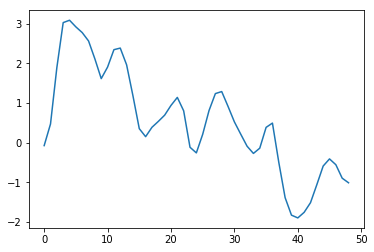

In [6]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 1.722963709159633


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.8976841593812779
Iteration 200/4000
Upper bound estimation = 0.8639071095499438
Iteration 300/4000
Upper bound estimation = 0.8558196623770298
Iteration 400/4000
Upper bound estimation = 0.862061721485245
Iteration 500/4000
Upper bound estimation = 0.84127174143036
Iteration 600/4000
Upper bound estimation = 0.8298604773416215
Iteration 700/4000
Upper bound estimation = 0.8519404305825823
Iteration 800/4000
Upper bound estimation = 0.8110704238285698
Iteration 900/4000
Upper bound estimation = 0.8010369191474043
Iteration 1000/4000
Upper bound estimation = 0.7916847017085783
Iteration 1100/4000
Upper bound estimation = 0.7792289289368989
Iteration 1200/4000
Upper bound estimation = 0.7666753788734751
Iteration 1300/4000
Upper bound estimation = 0.7411113418321849
Iteration 1400/4000
Upper bound estimation = 0.7227356377582418
Iteration 1500/4000
Upper bound estimation = 0.724087790321621
Iteration 1600/4000
Upper bound estimation = 0.705409

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.20977548248136935


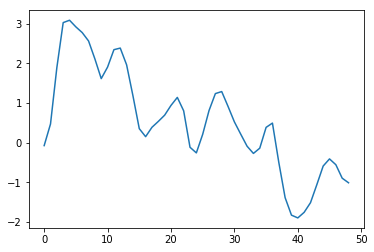

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 1.7229637091218093


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.1192345839787308
L = 0.03
rho = 0.1197237082199601
L = 0.04
rho = 0.12041600607649261
L = 0.05
rho = 0.12122557915423994
L = 0.060000000000000005
rho = 0.1220998333650491
L = 0.07
rho = 0.12301013344751996
L = 0.08
rho = 0.12394134915856833
L = 0.09
rho = 0.12488541690221851
L = 0.09999999999999999
rho = 0.1258379499282916
L = 0.10999999999999999
rho = 0.12679651304863634
L = 0.11999999999999998
rho = 0.1277597329532134
L = 0.12999999999999998
rho = 0.1287268261898843
L = 0.13999999999999999
rho = 0.12969734135721192
L = 0.15
rho = 0.13067101489644
L = 0.16
rho = 0.13164768895520843
L = 0.17
rho = 0.13262726391662807
L = 0.18000000000000002
rho = 0.13360967054896564
L = 0.19000000000000003
rho = 0.13459485334400864
L = 0.20000000000000004
rho = 0.13558276027967867
L = 0.21000000000000005
rho = 0.13657333632685534
L = 0.22000000000000006
rho = 0.13756651921667137
L = 0.23000000000000007
rho = 0.13856223666628434
L = 0.24000000000000007
rho = 0.1395

the 26 steps
rho = 0.21425273034132694
the 27 steps
rho = 0.21422943014067372
the 28 steps
rho = 0.21420624445530997
the 29 steps
rho = 0.2141831715131259
the 30 steps
rho = 0.2141602095752102
the 31 steps
rho = 0.21413735693530767
the 32 steps
rho = 0.2141146119192486
the 33 steps
rho = 0.21409197288442572
the 34 steps
rho = 0.21406943821923993
the 35 steps
rho = 0.21404700634256818
the 36 steps
rho = 0.21402467570323702
the 37 steps
rho = 0.21400244477949962
the 38 steps
rho = 0.21398031207851417
the 39 steps
rho = 0.21395827613583887
the 40 steps
rho = 0.21393633551491834
the 41 steps
rho = 0.21391448880659458
the 42 steps
rho = 0.2138927346286078
the 43 steps
rho = 0.21387107162510513
the 44 steps
rho = 0.2138494984661726
the 45 steps
rho = 0.21382801384735767
the 46 steps
rho = 0.2138066164891958
the 47 steps
rho = 0.21378530513675642
the 48 steps
rho = 0.21376407855919138
the 49 steps
rho = 0.21374293554928078
the 50 steps
rho = 0.2137218749229959
the 51 steps
rho = 0.21370089551

the 210 steps
rho = 0.21097676429676657
the 211 steps
rho = 0.2109621434747132
the 212 steps
rho = 0.21094754620227027
the 213 steps
rho = 0.2109329724157337
the 214 steps
rho = 0.21091842205232259
the 215 steps
rho = 0.210903895050155
the 216 steps
rho = 0.21088939134823487
the 217 steps
rho = 0.2108749108864318
the 218 steps
rho = 0.21086045360546662
the 219 steps
rho = 0.21084601944689169
the 220 steps
rho = 0.21083160835307682
the 221 steps
rho = 0.21081722026719052
the 222 steps
rho = 0.2108028551331847
the 223 steps
rho = 0.21078851289577705
the 224 steps
rho = 0.2107741935004476
the 225 steps
rho = 0.21075989689340124
the 226 steps
rho = 0.21074562302157412
the 227 steps
rho = 0.21073137183260846
the 228 steps
rho = 0.21071714327483837
the 229 steps
rho = 0.21070293729727863
the 230 steps
rho = 0.2106887538496096
the 231 steps
rho = 0.2106745928821656
the 232 steps
rho = 0.21066045434592076
the 233 steps
rho = 0.21064633819246956
the 234 steps
rho = 0.21063224437402037
the 235 s

the 391 steps
rho = 0.20867402388231357
the 392 steps
rho = 0.2086630558147319
the 393 steps
rho = 0.20865210542782078
the 394 steps
rho = 0.20864117269528643
the 395 steps
rho = 0.2086302575907864
the 396 steps
rho = 0.20861936008794038
the 397 steps
rho = 0.20860848016031963
the 398 steps
rho = 0.2085976177814487
the 399 steps
rho = 0.20858677292481156
the 400 steps
rho = 0.20857594556383838
the 401 steps
rho = 0.20856513567192023
the 402 steps
rho = 0.2085543432223997
the 403 steps
rho = 0.2085435681885719
the 404 steps
rho = 0.20853281054368808
the 405 steps
rho = 0.20852207026094768
the 406 steps
rho = 0.20851134731350981
the 407 steps
rho = 0.2085006416744825
the 408 steps
rho = 0.20848995331692713
the 409 steps
rho = 0.20847928221385958
the 410 steps
rho = 0.2084686283382475
the 411 steps
rho = 0.20845799166301252
the 412 steps
rho = 0.20844737216102585
the 413 steps
rho = 0.20843676980511552
the 414 steps
rho = 0.2084261845680615
the 415 steps
rho = 0.20841561642259215
the 416 

the 571 steps
rho = 0.20695769856172236
the 572 steps
rho = 0.2069494519950739
the 573 steps
rho = 0.2069412178348455
the 574 steps
rho = 0.2069329960510138
the 575 steps
rho = 0.2069247866135711
the 576 steps
rho = 0.20691658949253713
the 577 steps
rho = 0.2069084046579545
the 578 steps
rho = 0.20690023207988706
the 579 steps
rho = 0.20689207172842244
the 580 steps
rho = 0.20688392357367674
the 581 steps
rho = 0.20687578758578426
the 582 steps
rho = 0.20686766373490761
the 583 steps
rho = 0.2068595519912354
the 584 steps
rho = 0.2068514523249836
the 585 steps
rho = 0.20684336470639045
the 586 steps
rho = 0.20683528910572477
the 587 steps
rho = 0.20682722549328034
the 588 steps
rho = 0.2068191738393815
the 589 steps
rho = 0.2068111341143726
the 590 steps
rho = 0.20680310628863757
the 591 steps
rho = 0.20679509033258178
the 592 steps
rho = 0.2067870862166388
the 593 steps
rho = 0.20677909391127994
the 594 steps
rho = 0.20677111338699863
the 595 steps
rho = 0.2067631446143206
the 596 ste

the 752 steps
rho = 0.20563947691154144
the 753 steps
rho = 0.20563302254980398
the 754 steps
rho = 0.20562657581352686
the 755 steps
rho = 0.20562013668086848
the 756 steps
rho = 0.20561370513004182
the 757 steps
rho = 0.20560728113931212
the 758 steps
rho = 0.2056008646869991
the 759 steps
rho = 0.20559445575147972
the 760 steps
rho = 0.20558805431117455
the 761 steps
rho = 0.20558166034456646
the 762 steps
rho = 0.20557527383018748
the 763 steps
rho = 0.2055688947466204
the 764 steps
rho = 0.20556252307250508
the 765 steps
rho = 0.20555615878653444
the 766 steps
rho = 0.20554980186745125
the 767 steps
rho = 0.20554345229405263
the 768 steps
rho = 0.2055371100451887
the 769 steps
rho = 0.20553077509976078
the 770 steps
rho = 0.2055244474367264
the 771 steps
rho = 0.20551812703509215
the 772 steps
rho = 0.20551181387391887
the 773 steps
rho = 0.20550550793231798
the 774 steps
rho = 0.20549920918945822
the 775 steps
rho = 0.20549291762455538
the 776 steps
rho = 0.20548663321687854
the 

the 921 steps
rho = 0.20464135959462035
the 922 steps
rho = 0.20463592375914047
the 923 steps
rho = 0.20463049255659407
the 924 steps
rho = 0.20462506597301489
the 925 steps
rho = 0.2046196439944741
the 926 steps
rho = 0.20461422660708406
the 927 steps
rho = 0.20460881379698964
the 928 steps
rho = 0.20460340555038053
the 929 steps
rho = 0.2045980018534809
the 930 steps
rho = 0.20459260269255314
the 931 steps
rho = 0.20458720805389644
the 932 steps
rho = 0.20458181792385355
the 933 steps
rho = 0.20457643228879716
the 934 steps
rho = 0.20457105113514248
the 935 steps
rho = 0.20456567444934332
the 936 steps
rho = 0.20456030221788576
the 937 steps
rho = 0.2045549344272987
the 938 steps
rho = 0.2045495710641439
the 939 steps
rho = 0.20454421211502546
the 940 steps
rho = 0.20453885756657908
the 941 steps
rho = 0.20453350740548157
the 942 steps
rho = 0.20452816161844464
the 943 steps
rho = 0.20452282019221735
the 944 steps
rho = 0.20451748311358742
the 945 steps
rho = 0.20451215036937584
the 

the 1082 steps
rho = 0.2038172942424419
the 1083 steps
rho = 0.2038124484484963
the 1084 steps
rho = 0.20380760547917015
the 1085 steps
rho = 0.2038027653256914
the 1086 steps
rho = 0.20379792797931173
the 1087 steps
rho = 0.20379309343131322
the 1088 steps
rho = 0.2037882616730011
the 1089 steps
rho = 0.20378343269571292
the 1090 steps
rho = 0.2037786064908053
the 1091 steps
rho = 0.2037737830496692
the 1092 steps
rho = 0.20376896236371717
the 1093 steps
rho = 0.2037641444243902
the 1094 steps
rho = 0.20375932922315293
the 1095 steps
rho = 0.20375451675150197
the 1096 steps
rho = 0.20374970700095738
the 1097 steps
rho = 0.20374489996306158
the 1098 steps
rho = 0.20374009562939124
the 1099 steps
rho = 0.2037352939915425
the 1100 steps
rho = 0.20373049504114002
the 1101 steps
rho = 0.2037256987698356
the 1102 steps
rho = 0.20372090516930494
the 1103 steps
rho = 0.20371611423125166
the 1104 steps
rho = 0.20371132594740632
the 1105 steps
rho = 0.20370654030951882
the 1106 steps
rho = 0.20

the 1230 steps
rho = 0.20312668501205763
the 1231 steps
rho = 0.20312217504031493
the 1232 steps
rho = 0.20311766685916707
the 1233 steps
rho = 0.20311316046324382
the 1234 steps
rho = 0.20310865584720036
the 1235 steps
rho = 0.20310415300570728
the 1236 steps
rho = 0.2030996519334539
the 1237 steps
rho = 0.20309515262515201
the 1238 steps
rho = 0.20309065507552757
the 1239 steps
rho = 0.20308615927933021
the 1240 steps
rho = 0.20308166523132368
the 1241 steps
rho = 0.20307717292629493
the 1242 steps
rho = 0.2030726823590483
the 1243 steps
rho = 0.20306819352440456
the 1244 steps
rho = 0.2030637064172078
the 1245 steps
rho = 0.20305922103231416
the 1246 steps
rho = 0.20305473736460655
the 1247 steps
rho = 0.20305025540898017
the 1248 steps
rho = 0.20304577516035008
the 1249 steps
rho = 0.20304129661365072
the 1250 steps
rho = 0.20303681976383553
the 1251 steps
rho = 0.2030323446058746
the 1252 steps
rho = 0.20302787113475637
the 1253 steps
rho = 0.2030233993454909
the 1254 steps
rho = 

the 1380 steps
rho = 0.2024675999956702
the 1381 steps
rho = 0.20246330822229197
the 1382 steps
rho = 0.20245901762200158
the 1383 steps
rho = 0.20245472819176863
the 1384 steps
rho = 0.2024504399285782
the 1385 steps
rho = 0.20244615282942519
the 1386 steps
rho = 0.2024418668913179
the 1387 steps
rho = 0.20243758211127685
the 1388 steps
rho = 0.20243329848633487
the 1389 steps
rho = 0.20242901601353347
the 1390 steps
rho = 0.20242473468992897
the 1391 steps
rho = 0.20242045451259025
the 1392 steps
rho = 0.2024161754785946
the 1393 steps
rho = 0.20241189758503494
the 1394 steps
rho = 0.20240762082901245
the 1395 steps
rho = 0.20240334520764341
the 1396 steps
rho = 0.20239907071805183
the 1397 steps
rho = 0.20239479735737526
the 1398 steps
rho = 0.2023905251227654
the 1399 steps
rho = 0.20238625401138002
the 1400 steps
rho = 0.20238198402039317
the 1401 steps
rho = 0.20237771514698635
the 1402 steps
rho = 0.20237344738835608
the 1403 steps
rho = 0.2023691807417075
the 1404 steps
rho = 0

the 1529 steps
rho = 0.20183964000965304
the 1530 steps
rho = 0.20183549539617182
the 1531 steps
rho = 0.2018313516169634
the 1532 steps
rho = 0.20182720867038673
the 1533 steps
rho = 0.2018230665548049
the 1534 steps
rho = 0.20181892526858858
the 1535 steps
rho = 0.20181478481011658
the 1536 steps
rho = 0.20181064517777114
the 1537 steps
rho = 0.2018065063699423
the 1538 steps
rho = 0.20180236838503038
the 1539 steps
rho = 0.2017982312214364
the 1540 steps
rho = 0.20179409487757152
the 1541 steps
rho = 0.2017899593518532
the 1542 steps
rho = 0.20178582464270592
the 1543 steps
rho = 0.20178169074855848
the 1544 steps
rho = 0.20177755766784788
the 1545 steps
rho = 0.201773425399018
the 1546 steps
rho = 0.20176929394051715
the 1547 steps
rho = 0.20176516329080185
the 1548 steps
rho = 0.20176103344833415
the 1549 steps
rho = 0.2017569044115834
the 1550 steps
rho = 0.20175277617902312
the 1551 steps
rho = 0.20174864874913587
the 1552 steps
rho = 0.20174452212041016
the 1553 steps
rho = 0.2

the 1668 steps
rho = 0.2012709111755766
the 1669 steps
rho = 0.20126686935656846
the 1670 steps
rho = 0.20126282819751942
the 1671 steps
rho = 0.20125878769749625
the 1672 steps
rho = 0.20125474785557268
the 1673 steps
rho = 0.20125070867082342
the 1674 steps
rho = 0.2012466701423299
the 1675 steps
rho = 0.20124263226917394
the 1676 steps
rho = 0.20123859505044384
the 1677 steps
rho = 0.20123455848522984
the 1678 steps
rho = 0.20123052257262378
the 1679 steps
rho = 0.20122648731172607
the 1680 steps
rho = 0.20122245270163797
the 1681 steps
rho = 0.20121841874146298
the 1682 steps
rho = 0.20121438543031053
the 1683 steps
rho = 0.20121035276729182
the 1684 steps
rho = 0.20120632075152367
the 1685 steps
rho = 0.20120228938212378
the 1686 steps
rho = 0.2011982586582159
the 1687 steps
rho = 0.20119422857892416
the 1688 steps
rho = 0.20119019914337843
the 1689 steps
rho = 0.2011861703507136
the 1690 steps
rho = 0.201182142200064
the 1691 steps
rho = 0.20117811469056854
the 1692 steps
rho = 0

the 1807 steps
rho = 0.20071506921132481
the 1808 steps
rho = 0.20071111159790822
the 1809 steps
rho = 0.20070715454428598
the 1810 steps
rho = 0.2007031980499126
the 1811 steps
rho = 0.20069924211424253
the 1812 steps
rho = 0.2006952867367351
the 1813 steps
rho = 0.20069133191685035
the 1814 steps
rho = 0.20068737765404893
the 1815 steps
rho = 0.20068342394779332
the 1816 steps
rho = 0.20067947079755116
the 1817 steps
rho = 0.20067551820278878
the 1818 steps
rho = 0.2006715661629759
the 1819 steps
rho = 0.20066761467758454
the 1820 steps
rho = 0.20066366374608766
the 1821 steps
rho = 0.2006597133679597
the 1822 steps
rho = 0.20065576354267856
the 1823 steps
rho = 0.20065181426972256
the 1824 steps
rho = 0.20064786554857425
the 1825 steps
rho = 0.20064391737871423
the 1826 steps
rho = 0.20063996975962983
the 1827 steps
rho = 0.2006360226908048
the 1828 steps
rho = 0.2006320761717304
the 1829 steps
rho = 0.20062813020189474
the 1830 steps
rho = 0.20062418478078997
the 1831 steps
rho = 0

the 1948 steps
rho = 0.20016234926738566
the 1949 steps
rho = 0.20015846598763626
the 1950 steps
rho = 0.20015458320701465
the 1951 steps
rho = 0.20015070092518708
the 1952 steps
rho = 0.20014681914182253
the 1953 steps
rho = 0.20014293785658915
the 1954 steps
rho = 0.2001390570691556
the 1955 steps
rho = 0.20013517677919426
the 1956 steps
rho = 0.20013129698637447
the 1957 steps
rho = 0.20012741769037196
the 1958 steps
rho = 0.20012353889085974
the 1959 steps
rho = 0.20011966058751027
the 1960 steps
rho = 0.20011578278000472
the 1961 steps
rho = 0.20011190546801752
the 1962 steps
rho = 0.20010802865122684
the 1963 steps
rho = 0.20010415232931214
the 1964 steps
rho = 0.20010027650195406
the 1965 steps
rho = 0.20009640116883468
the 1966 steps
rho = 0.20009252632963498
the 1967 steps
rho = 0.20008865198404033
the 1968 steps
rho = 0.20008477813173506
the 1969 steps
rho = 0.20008090477240228
the 1970 steps
rho = 0.20007703190573153
the 1971 steps
rho = 0.20007315953141006
the 1972 steps
rh

the 2084 steps
rho = 0.19963868205572416
the 2085 steps
rho = 0.199634863994595
the 2086 steps
rho = 0.19963104639580648
the 2087 steps
rho = 0.19962722925914053
the 2088 steps
rho = 0.1996234125843808
the 2089 steps
rho = 0.19961959637131296
the 2090 steps
rho = 0.19961578061972088
the 2091 steps
rho = 0.19961196532939182
the 2092 steps
rho = 0.19960815050011155
the 2093 steps
rho = 0.19960433613166798
the 2094 steps
rho = 0.19960052222384841
the 2095 steps
rho = 0.1995967087764396
the 2096 steps
rho = 0.19959289578923392
the 2097 steps
rho = 0.19958908326201874
the 2098 steps
rho = 0.19958527119458536
the 2099 steps
rho = 0.1995814595867252
the 2100 steps
rho = 0.19957764843822778
the 2101 steps
rho = 0.19957383774888915
the 2102 steps
rho = 0.19957002751849826
the 2103 steps
rho = 0.19956621774685043
the 2104 steps
rho = 0.19956240843374012
the 2105 steps
rho = 0.199558599578961
the 2106 steps
rho = 0.19955479118230882
the 2107 steps
rho = 0.19955098324357926
the 2108 steps
rho = 0.

the 2223 steps
rho = 0.1991123198140491
the 2224 steps
rho = 0.19910856419451317
the 2225 steps
rho = 0.19910480901255895
the 2226 steps
rho = 0.19910105426804223
the 2227 steps
rho = 0.19909729996081815
the 2228 steps
rho = 0.19909354609074442
the 2229 steps
rho = 0.19908979265767568
the 2230 steps
rho = 0.19908603966146937
the 2231 steps
rho = 0.19908228710198075
the 2232 steps
rho = 0.1990785349790696
the 2233 steps
rho = 0.19907478329259395
the 2234 steps
rho = 0.19907103204241064
the 2235 steps
rho = 0.1990672812283799
the 2236 steps
rho = 0.1990635308503589
the 2237 steps
rho = 0.1990597809082091
the 2238 steps
rho = 0.19905603140178876
the 2239 steps
rho = 0.19905228233095992
the 2240 steps
rho = 0.19904853369558134
the 2241 steps
rho = 0.1990447854955155
the 2242 steps
rho = 0.19904103773062232
the 2243 steps
rho = 0.19903729040076537
the 2244 steps
rho = 0.19903354350580504
the 2245 steps
rho = 0.199029797045606
the 2246 steps
rho = 0.19902605102002827
the 2247 steps
rho = 0.1

the 2362 steps
rho = 0.19859442757234327
the 2363 steps
rho = 0.19859073154467127
the 2364 steps
rho = 0.19858703593776245
the 2365 steps
rho = 0.19858334075152032
the 2366 steps
rho = 0.19857964598584166
the 2367 steps
rho = 0.19857595164062924
the 2368 steps
rho = 0.19857225771578196
the 2369 steps
rho = 0.19856856421120073
the 2370 steps
rho = 0.1985648711267868
the 2371 steps
rho = 0.1985611784624423
the 2372 steps
rho = 0.1985574862180676
the 2373 steps
rho = 0.1985537943935651
the 2374 steps
rho = 0.19855010298883616
the 2375 steps
rho = 0.19854641200378403
the 2376 steps
rho = 0.19854272143830973
the 2377 steps
rho = 0.1985390312923178
the 2378 steps
rho = 0.1985353415657104
the 2379 steps
rho = 0.19853165225839126
the 2380 steps
rho = 0.1985279633702623
the 2381 steps
rho = 0.19852427490122865
the 2382 steps
rho = 0.19852058685119506
the 2383 steps
rho = 0.19851689922006366
the 2384 steps
rho = 0.19851321200773928
the 2385 steps
rho = 0.19850952521412793
the 2386 steps
rho = 0.

the 2501 steps
rho = 0.19808467483872658
the 2502 steps
rho = 0.19808103643551703
the 2503 steps
rho = 0.19807739844123956
the 2504 steps
rho = 0.19807376085582465
the 2505 steps
rho = 0.19807012367919602
the 2506 steps
rho = 0.19806648691128667
the 2507 steps
rho = 0.1980628505520238
the 2508 steps
rho = 0.19805921460133508
the 2509 steps
rho = 0.19805557905914975
the 2510 steps
rho = 0.198051943925396
the 2511 steps
rho = 0.19804830920000588
the 2512 steps
rho = 0.1980446748829061
the 2513 steps
rho = 0.1980410409740264
the 2514 steps
rho = 0.19803740747329623
the 2515 steps
rho = 0.19803377438064862
the 2516 steps
rho = 0.1980301416960084
the 2517 steps
rho = 0.19802650941930935
the 2518 steps
rho = 0.19802287755048034
the 2519 steps
rho = 0.19801924608945146
the 2520 steps
rho = 0.19801561503615434
the 2521 steps
rho = 0.19801198439052092
the 2522 steps
rho = 0.19800835415247714
the 2523 steps
rho = 0.19800472432195865
the 2524 steps
rho = 0.19800109489889628
the 2525 steps
rho = 0

the 2639 steps
rho = 0.19758641213761524
the 2640 steps
rho = 0.19758282954879894
the 2641 steps
rho = 0.19757924736029986
the 2642 steps
rho = 0.1975756655720632
the 2643 steps
rho = 0.1975720841840365
the 2644 steps
rho = 0.19756850319616526
the 2645 steps
rho = 0.19756492260839567
the 2646 steps
rho = 0.1975613424206732
the 2647 steps
rho = 0.1975577626329449
the 2648 steps
rho = 0.1975541832451569
the 2649 steps
rho = 0.19755060425725557
the 2650 steps
rho = 0.19754702566918897
the 2651 steps
rho = 0.19754344748090197
the 2652 steps
rho = 0.1975398696923424
the 2653 steps
rho = 0.19753629230345696
the 2654 steps
rho = 0.1975327153141931
the 2655 steps
rho = 0.1975291387244966
the 2656 steps
rho = 0.1975255625343156
the 2657 steps
rho = 0.19752198674359764
the 2658 steps
rho = 0.19751841135229162
the 2659 steps
rho = 0.19751483636034173
the 2660 steps
rho = 0.1975112617676973
the 2661 steps
rho = 0.19750768757430606
the 2662 steps
rho = 0.19750411378011554
the 2663 steps
rho = 0.197

the 2819 steps
rho = 0.19694794727509785
the 2820 steps
rho = 0.1969444359537025
the 2821 steps
rho = 0.19694092502420127
the 2822 steps
rho = 0.19693741448655191
the 2823 steps
rho = 0.19693390434071437
the 2824 steps
rho = 0.1969303945866456
the 2825 steps
rho = 0.19692688522430765
the 2826 steps
rho = 0.19692337625365902
the 2827 steps
rho = 0.19691986767465847
the 2828 steps
rho = 0.1969163594872658
the 2829 steps
rho = 0.19691285169144102
the 2830 steps
rho = 0.19690934428714263
the 2831 steps
rho = 0.19690583727433145
the 2832 steps
rho = 0.1969023306529662
the 2833 steps
rho = 0.19689882442300627
the 2834 steps
rho = 0.1968953185844109
the 2835 steps
rho = 0.1968918131371418
the 2836 steps
rho = 0.1968883080811579
the 2837 steps
rho = 0.1968848034164185
the 2838 steps
rho = 0.19688129914288502
the 2839 steps
rho = 0.196877795260515
the 2840 steps
rho = 0.19687429176927
the 2841 steps
rho = 0.19687078866910898
the 2842 steps
rho = 0.19686728595999542
the 2843 steps
rho = 0.196863

the 2957 steps
rho = 0.1964670726204086
the 2958 steps
rho = 0.19646361501253515
the 2959 steps
rho = 0.1964601577913037
the 2960 steps
rho = 0.19645670095668005
the 2961 steps
rho = 0.19645324450862905
the 2962 steps
rho = 0.19644978844711544
the 2963 steps
rho = 0.19644633277210097
the 2964 steps
rho = 0.19644287748355158
the 2965 steps
rho = 0.1964394225814333
the 2966 steps
rho = 0.19643596806570848
the 2967 steps
rho = 0.19643251393634095
the 2968 steps
rho = 0.19642906019329742
the 2969 steps
rho = 0.19642560683654056
the 2970 steps
rho = 0.19642215386603423
the 2971 steps
rho = 0.19641870128174593
the 2972 steps
rho = 0.1964152490836387
the 2973 steps
rho = 0.19641179727167524
the 2974 steps
rho = 0.1964083458458228
the 2975 steps
rho = 0.19640489480604467
the 2976 steps
rho = 0.19640144415230587
the 2977 steps
rho = 0.19639799388457077
the 2978 steps
rho = 0.19639454400280484
the 2979 steps
rho = 0.1963910945069713
the 2980 steps
rho = 0.196387645397037
the 2981 steps
rho = 0.1

the 3099 steps
rho = 0.19597994663561158
the 3100 steps
rho = 0.1959765435827248
the 3101 steps
rho = 0.19597314091159465
the 3102 steps
rho = 0.19596973862218403
the 3103 steps
rho = 0.19596633671446045
the 3104 steps
rho = 0.19596293518839186
the 3105 steps
rho = 0.1959595340439417
the 3106 steps
rho = 0.1959561332810803
the 3107 steps
rho = 0.19595273289977191
the 3108 steps
rho = 0.19594933289998223
the 3109 steps
rho = 0.19594593328168058
the 3110 steps
rho = 0.1959425340448304
the 3111 steps
rho = 0.1959391351894009
the 3112 steps
rho = 0.1959357367153568
the 3113 steps
rho = 0.19593233862266557
the 3114 steps
rho = 0.1959289409112926
the 3115 steps
rho = 0.1959255435812063
the 3116 steps
rho = 0.19592214663237123
the 3117 steps
rho = 0.19591875006475565
the 3118 steps
rho = 0.1959153538783248
the 3119 steps
rho = 0.19591195807304834
the 3120 steps
rho = 0.1959085626488883
the 3121 steps
rho = 0.19590516760581406
the 3122 steps
rho = 0.19590177294379058
the 3123 steps
rho = 0.195

the 3243 steps
rho = 0.19549382130036747
the 3244 steps
rho = 0.19549047287675894
the 3245 steps
rho = 0.1954871248301038
the 3246 steps
rho = 0.1954837771603705
the 3247 steps
rho = 0.19548042986752404
the 3248 steps
rho = 0.195477082951533
the 3249 steps
rho = 0.19547373641236168
the 3250 steps
rho = 0.19547039024997773
the 3251 steps
rho = 0.19546704446434662
the 3252 steps
rho = 0.19546369905543717
the 3253 steps
rho = 0.19546035402321343
the 3254 steps
rho = 0.19545700936764349
the 3255 steps
rho = 0.19545366508869308
the 3256 steps
rho = 0.19545032118632977
the 3257 steps
rho = 0.19544697766051908
the 3258 steps
rho = 0.1954436345112267
the 3259 steps
rho = 0.19544029173842117
the 3260 steps
rho = 0.19543694934206918
the 3261 steps
rho = 0.19543360732213405
the 3262 steps
rho = 0.19543026567858415
the 3263 steps
rho = 0.19542692441138754
the 3264 steps
rho = 0.19542358352050843
the 3265 steps
rho = 0.1954202430059149
the 3266 steps
rho = 0.19541690286757152
the 3267 steps
rho = 0

the 3390 steps
rho = 0.1950056306653997
the 3391 steps
rho = 0.1950023372917256
the 3392 steps
rho = 0.19499904429001
the 3393 steps
rho = 0.1949957516602177
the 3394 steps
rho = 0.19499245940231566
the 3395 steps
rho = 0.1949891675162652
the 3396 steps
rho = 0.1949858760020367
the 3397 steps
rho = 0.19498258485959263
the 3398 steps
rho = 0.19497929408889672
the 3399 steps
rho = 0.1949760036899176
the 3400 steps
rho = 0.19497271366261715
the 3401 steps
rho = 0.19496942400696346
the 3402 steps
rho = 0.19496613472292035
the 3403 steps
rho = 0.19496284581045226
the 3404 steps
rho = 0.1949595572695252
the 3405 steps
rho = 0.19495626910010586
the 3406 steps
rho = 0.19495298130215516
the 3407 steps
rho = 0.19494969387564193
the 3408 steps
rho = 0.1949464068205302
the 3409 steps
rho = 0.1949431201367853
the 3410 steps
rho = 0.1949398338243708
the 3411 steps
rho = 0.19493654788325354
the 3412 steps
rho = 0.19493326231339786
the 3413 steps
rho = 0.19492997711476992
the 3414 steps
rho = 0.194926

the 3532 steps
rho = 0.19454167885044532
the 3533 steps
rho = 0.19453843794122574
the 3534 steps
rho = 0.1945351973989024
the 3535 steps
rho = 0.1945319572234391
the 3536 steps
rho = 0.19452871741479788
the 3537 steps
rho = 0.19452547797294203
the 3538 steps
rho = 0.19452223889783773
the 3539 steps
rho = 0.19451900018944465
the 3540 steps
rho = 0.1945157618477278
the 3541 steps
rho = 0.19451252387265128
the 3542 steps
rho = 0.1945092862641757
the 3543 steps
rho = 0.19450604902226687
the 3544 steps
rho = 0.19450281214688742
the 3545 steps
rho = 0.19449957563800033
the 3546 steps
rho = 0.19449633949556686
the 3547 steps
rho = 0.19449310371955392
the 3548 steps
rho = 0.1944898683099221
the 3549 steps
rho = 0.19448663326663534
the 3550 steps
rho = 0.19448339858965577
the 3551 steps
rho = 0.19448016427894804
the 3552 steps
rho = 0.1944769303344753
the 3553 steps
rho = 0.19447369675619874
the 3554 steps
rho = 0.19447046354408268
the 3555 steps
rho = 0.19446723069809027
the 3556 steps
rho = 0

the 3680 steps
rho = 0.19406599570053237
the 3681 steps
rho = 0.19406280868556178
the 3682 steps
rho = 0.1940596220319052
the 3683 steps
rho = 0.19405643573952577
the 3684 steps
rho = 0.1940532498083827
the 3685 steps
rho = 0.19405006423843607
the 3686 steps
rho = 0.1940468790296489
the 3687 steps
rho = 0.19404369418198283
the 3688 steps
rho = 0.1940405096953975
the 3689 steps
rho = 0.19403732556985467
the 3690 steps
rho = 0.19403414180531522
the 3691 steps
rho = 0.19403095840174123
the 3692 steps
rho = 0.19402777535909227
the 3693 steps
rho = 0.19402459267732983
the 3694 steps
rho = 0.19402141035641626
the 3695 steps
rho = 0.19401822839631144
the 3696 steps
rho = 0.19401504679697704
the 3697 steps
rho = 0.1940118655583743
the 3698 steps
rho = 0.19400868468046262
the 3699 steps
rho = 0.19400550416320472
the 3700 steps
rho = 0.19400232400656037
the 3701 steps
rho = 0.1939991442104919
the 3702 steps
rho = 0.19399596477495906
the 3703 steps
rho = 0.19399278569992381
the 3704 steps
rho = 0

the 3829 steps
rho = 0.19359509311513803
the 3830 steps
rho = 0.19359195950152677
the 3831 steps
rho = 0.1935888262433136
the 3832 steps
rho = 0.19358569334045958
the 3833 steps
rho = 0.19358256079292316
the 3834 steps
rho = 0.19357942860066257
the 3835 steps
rho = 0.19357629676363863
the 3836 steps
rho = 0.19357316528181143
the 3837 steps
rho = 0.19357003415513957
the 3838 steps
rho = 0.1935669033835821
the 3839 steps
rho = 0.1935637729670993
the 3840 steps
rho = 0.19356064290564962
the 3841 steps
rho = 0.19355751319919173
the 3842 steps
rho = 0.19355438384768753
the 3843 steps
rho = 0.19355125485109406
the 3844 steps
rho = 0.19354812620937167
the 3845 steps
rho = 0.19354499792247973
the 3846 steps
rho = 0.19354186999037695
the 3847 steps
rho = 0.19353874241302346
the 3848 steps
rho = 0.19353561519037793
the 3849 steps
rho = 0.19353248832239975
the 3850 steps
rho = 0.19352936180904892
the 3851 steps
rho = 0.1935262356502841
the 3852 steps
rho = 0.19352310984606316
the 3853 steps
rho =

the 3982 steps
rho = 0.193119758889378
the 3983 steps
rho = 0.19311667917542338
the 3984 steps
rho = 0.19311359981057363
the 3985 steps
rho = 0.1931105207947849
the 3986 steps
rho = 0.19310744212801711
the 3987 steps
rho = 0.19310436381022925
the 3988 steps
rho = 0.19310128584137806
the 3989 steps
rho = 0.19309820822142224
the 3990 steps
rho = 0.19309513095032177
the 3991 steps
rho = 0.19309205402803198
the 3992 steps
rho = 0.19308897745451545
the 3993 steps
rho = 0.19308590122972655
the 3994 steps
rho = 0.1930828253536263
the 3995 steps
rho = 0.19307974982617068
the 3996 steps
rho = 0.1930766746473207
the 3997 steps
rho = 0.19307359981703356
the 3998 steps
rho = 0.1930705253352672
the 3999 steps
rho = 0.19306745120197977
the 4000 steps
rho = 0.1930643774171314
the 4001 steps
rho = 0.1930613039806782
the 4002 steps
rho = 0.1930582308925795
the 4003 steps
rho = 0.1930551581527935
the 4004 steps
rho = 0.1930520857612801
the 4005 steps
rho = 0.19304901371799496
the 4006 steps
rho = 0.1930

the 4139 steps
rho = 0.19264049254670237
the 4140 steps
rho = 0.19263746713135993
the 4141 steps
rho = 0.19263444205857194
the 4142 steps
rho = 0.1926314173282989
the 4143 steps
rho = 0.1926283929404974
the 4144 steps
rho = 0.19262536889512616
the 4145 steps
rho = 0.19262234519214397
the 4146 steps
rho = 0.19261932183150893
the 4147 steps
rho = 0.19261629881317915
the 4148 steps
rho = 0.19261327613711338
the 4149 steps
rho = 0.19261025380327032
the 4150 steps
rho = 0.19260723181160805
the 4151 steps
rho = 0.19260421016208498
the 4152 steps
rho = 0.1926011888546593
the 4153 steps
rho = 0.19259816788929002
the 4154 steps
rho = 0.19259514726593394
the 4155 steps
rho = 0.19259212698455214
the 4156 steps
rho = 0.19258910704509968
the 4157 steps
rho = 0.1925860874475376
the 4158 steps
rho = 0.1925830681918247
the 4159 steps
rho = 0.19258004927791592
the 4160 steps
rho = 0.19257703070577364
the 4161 steps
rho = 0.19257401247535555
the 4162 steps
rho = 0.19257099458661736
the 4163 steps
rho = 

the 4299 steps
rho = 0.1921607556272118
the 4300 steps
rho = 0.19215778449452253
the 4301 steps
rho = 0.1921548136977983
the 4302 steps
rho = 0.1921518432369987
the 4303 steps
rho = 0.192148873112085
the 4304 steps
rho = 0.19214590332301482
the 4305 steps
rho = 0.19214293386974984
the 4306 steps
rho = 0.192139964752247
the 4307 steps
rho = 0.19213699597046657
the 4308 steps
rho = 0.19213402752437003
the 4309 steps
rho = 0.1921310594139139
the 4310 steps
rho = 0.19212809163906094
the 4311 steps
rho = 0.19212512419976788
the 4312 steps
rho = 0.19212215709599656
the 4313 steps
rho = 0.19211919032770441
the 4314 steps
rho = 0.1921162238948526
the 4315 steps
rho = 0.19211325779739932
the 4316 steps
rho = 0.1921102920353058
the 4317 steps
rho = 0.19210732660852983
the 4318 steps
rho = 0.19210436151703406
the 4319 steps
rho = 0.19210139676077498
the 4320 steps
rho = 0.192098432339713
the 4321 steps
rho = 0.19209546825380946
the 4322 steps
rho = 0.1920925045030214
the 4323 steps
rho = 0.192089

the 4462 steps
rho = 0.19168086836421475
the 4463 steps
rho = 0.19167795146723393
the 4464 steps
rho = 0.1916750348997762
the 4465 steps
rho = 0.1916721186618029
the 4466 steps
rho = 0.19166920275327548
the 4467 steps
rho = 0.19166628717415674
the 4468 steps
rho = 0.19166337192440713
the 4469 steps
rho = 0.19166045700398862
the 4470 steps
rho = 0.19165754241286323
the 4471 steps
rho = 0.1916546281509934
the 4472 steps
rho = 0.19165171421833943
the 4473 steps
rho = 0.19164880061486406
the 4474 steps
rho = 0.1916458873405301
the 4475 steps
rho = 0.19164297439529812
the 4476 steps
rho = 0.19164006177912898
the 4477 steps
rho = 0.19163714949198613
the 4478 steps
rho = 0.19163423753383044
the 4479 steps
rho = 0.19163132590462495
the 4480 steps
rho = 0.19162841460432956
the 4481 steps
rho = 0.19162550363290878
the 4482 steps
rho = 0.19162259299032325
the 4483 steps
rho = 0.19161968267653512
the 4484 steps
rho = 0.19161677269150584
the 4485 steps
rho = 0.19161386303519762
the 4486 steps
rho =

the 4626 steps
rho = 0.19120687448893978
the 4627 steps
rho = 0.19120401113382937
the 4628 steps
rho = 0.1912011481021916
the 4629 steps
rho = 0.19119828539399147
the 4630 steps
rho = 0.1911954230091934
the 4631 steps
rho = 0.19119256094776357
the 4632 steps
rho = 0.19118969920966383
the 4633 steps
rho = 0.19118683779486179
the 4634 steps
rho = 0.19118397670332113
the 4635 steps
rho = 0.19118111593500556
the 4636 steps
rho = 0.19117825548988232
the 4637 steps
rho = 0.19117539536791464
the 4638 steps
rho = 0.19117253556906721
the 4639 steps
rho = 0.19116967609330643
the 4640 steps
rho = 0.19116681694059529
the 4641 steps
rho = 0.19116395811089973
the 4642 steps
rho = 0.19116109960418504
the 4643 steps
rho = 0.1911582414204159
the 4644 steps
rho = 0.19115538355955683
the 4645 steps
rho = 0.19115252602157368
the 4646 steps
rho = 0.19114966880643033
the 4647 steps
rho = 0.19114681191409336
the 4648 steps
rho = 0.19114395534452763
the 4649 steps
rho = 0.19114109909769703
the 4650 steps
rho 

the 4793 steps
rho = 0.19073315158186846
the 4794 steps
rho = 0.19073034177340045
the 4795 steps
rho = 0.19072753228280456
the 4796 steps
rho = 0.1907247231100468
the 4797 steps
rho = 0.19072191425509744
the 4798 steps
rho = 0.19071910571792297
the 4799 steps
rho = 0.1907162974984948
the 4800 steps
rho = 0.19071348959677736
the 4801 steps
rho = 0.1907106820127421
the 4802 steps
rho = 0.1907078747463558
the 4803 steps
rho = 0.19070506779758908
the 4804 steps
rho = 0.19070226116640562
the 4805 steps
rho = 0.19069945485277973
the 4806 steps
rho = 0.1906966488566775
the 4807 steps
rho = 0.19069384317806587
the 4808 steps
rho = 0.1906910378169163
the 4809 steps
rho = 0.19068823277319424
the 4810 steps
rho = 0.19068542804687164
the 4811 steps
rho = 0.1906826236379147
the 4812 steps
rho = 0.19067981954629312
the 4813 steps
rho = 0.1906770157719747
the 4814 steps
rho = 0.19067421231492904
the 4815 steps
rho = 0.19067140917512446
the 4816 steps
rho = 0.19066860635252936
the 4817 steps
rho = 0.1

the 4958 steps
rho = 0.19027381133881494
the 4959 steps
rho = 0.19027105356655954
the 4960 steps
rho = 0.19026829610724877
the 4961 steps
rho = 0.19026553896085163
the 4962 steps
rho = 0.19026278212734118
the 4963 steps
rho = 0.19026002560668964
the 4964 steps
rho = 0.190257269398869
the 4965 steps
rho = 0.19025451350385175
the 4966 steps
rho = 0.1902517579216084
the 4967 steps
rho = 0.190249002652113
the 4968 steps
rho = 0.1902462476953359
the 4969 steps
rho = 0.19024349305125052
the 4970 steps
rho = 0.19024073871983016
the 4971 steps
rho = 0.19023798470104383
the 4972 steps
rho = 0.19023523099486542
the 4973 steps
rho = 0.19023247760126807
the 4974 steps
rho = 0.19022972452022352
the 4975 steps
rho = 0.19022697175170233
the 4976 steps
rho = 0.19022421929567893
the 4977 steps
rho = 0.1902214671521257
the 4978 steps
rho = 0.1902187153210133
the 4979 steps
rho = 0.1902159638023163
the 4980 steps
rho = 0.1902132125960044
the 4981 steps
rho = 0.19021046170205305
the 4982 steps
rho = 0.190

the 5124 steps
rho = 0.18982028658409736
the 5125 steps
rho = 0.18981758039286312
the 5126 steps
rho = 0.18981487451021453
the 5127 steps
rho = 0.1898121689361264
the 5128 steps
rho = 0.189809463670577
the 5129 steps
rho = 0.18980675871354005
the 5130 steps
rho = 0.18980405406499112
the 5131 steps
rho = 0.18980134972490592
the 5132 steps
rho = 0.18979864569326077
the 5133 steps
rho = 0.18979594197002983
the 5134 steps
rho = 0.18979323855518979
the 5135 steps
rho = 0.18979053544871666
the 5136 steps
rho = 0.18978783265058422
the 5137 steps
rho = 0.18978513016077064
the 5138 steps
rho = 0.18978242797925005
the 5139 steps
rho = 0.18977972610599794
the 5140 steps
rho = 0.18977702454099118
the 5141 steps
rho = 0.1897743232842046
the 5142 steps
rho = 0.18977162233561534
the 5143 steps
rho = 0.18976892169519685
the 5144 steps
rho = 0.1897662213629276
the 5145 steps
rho = 0.18976352133878202
the 5146 steps
rho = 0.18976082162273594
the 5147 steps
rho = 0.18975812221476485
the 5148 steps
rho = 

the 5290 steps
rho = 0.18937526716141476
the 5291 steps
rho = 0.18937261187403476
the 5292 steps
rho = 0.1893699568914297
the 5293 steps
rho = 0.18936730221357578
the 5294 steps
rho = 0.1893646478404523
the 5295 steps
rho = 0.189361993772039
the 5296 steps
rho = 0.18935934000831225
the 5297 steps
rho = 0.18935668654925314
the 5298 steps
rho = 0.18935403339483764
the 5299 steps
rho = 0.18935138054504605
the 5300 steps
rho = 0.18934872799985522
the 5301 steps
rho = 0.1893460757592457
the 5302 steps
rho = 0.18934342382319638
the 5303 steps
rho = 0.1893407721916827
the 5304 steps
rho = 0.18933812086468724
the 5305 steps
rho = 0.18933546984218796
the 5306 steps
rho = 0.18933281912416075
the 5307 steps
rho = 0.18933016871058736
the 5308 steps
rho = 0.18932751860144414
the 5309 steps
rho = 0.18932486879671134
the 5310 steps
rho = 0.18932221929636736
the 5311 steps
rho = 0.18931957010039216
the 5312 steps
rho = 0.1893169212087621
the 5313 steps
rho = 0.18931427262145845
the 5314 steps
rho = 0.

the 5455 steps
rho = 0.18894125297213615
the 5456 steps
rho = 0.18893864769240715
the 5457 steps
rho = 0.18893604271410044
the 5458 steps
rho = 0.18893343803719695
the 5459 steps
rho = 0.18893083366167612
the 5460 steps
rho = 0.18892822958752037
the 5461 steps
rho = 0.1889256258147102
the 5462 steps
rho = 0.18892302234322525
the 5463 steps
rho = 0.18892041917304675
the 5464 steps
rho = 0.18891781630415733
the 5465 steps
rho = 0.18891521373653633
the 5466 steps
rho = 0.18891261147016475
the 5467 steps
rho = 0.1889100095050227
the 5468 steps
rho = 0.18890740784109264
the 5469 steps
rho = 0.1889048064783533
the 5470 steps
rho = 0.18890220541678734
the 5471 steps
rho = 0.18889960465637584
the 5472 steps
rho = 0.18889700419709865
the 5473 steps
rho = 0.1888944040389381
the 5474 steps
rho = 0.18889180418187404
the 5475 steps
rho = 0.18888920462588696
the 5476 steps
rho = 0.18888660537095772
the 5477 steps
rho = 0.18888400641706882
the 5478 steps
rho = 0.18888140776420034
the 5479 steps
rho =

the 5620 steps
rho = 0.18851544622397076
the 5621 steps
rho = 0.18851289042599656
the 5622 steps
rho = 0.18851033492639946
the 5623 steps
rho = 0.18850777972516372
the 5624 steps
rho = 0.1885052248222686
the 5625 steps
rho = 0.18850267021769787
the 5626 steps
rho = 0.1885001159114338
the 5627 steps
rho = 0.18849756190345723
the 5628 steps
rho = 0.18849500819375242
the 5629 steps
rho = 0.18849245478229976
the 5630 steps
rho = 0.1884899016690837
the 5631 steps
rho = 0.18848734885408433
the 5632 steps
rho = 0.18848479633728354
the 5633 steps
rho = 0.18848224411866585
the 5634 steps
rho = 0.18847969219821212
the 5635 steps
rho = 0.18847714057590526
the 5636 steps
rho = 0.18847458925172605
the 5637 steps
rho = 0.1884720382256584
the 5638 steps
rho = 0.18846948749768414
the 5639 steps
rho = 0.18846693706778517
the 5640 steps
rho = 0.18846438693594394
the 5641 steps
rho = 0.18846183710214187
the 5642 steps
rho = 0.18845928756636413
the 5643 steps
rho = 0.18845673832859
the 5644 steps
rho = 0.

the 5785 steps
rho = 0.1880977636545625
the 5786 steps
rho = 0.1880952568511921
the 5787 steps
rho = 0.18809275034331513
the 5788 steps
rho = 0.1880902441309139
the 5789 steps
rho = 0.18808773821397065
the 5790 steps
rho = 0.18808523259246834
the 5791 steps
rho = 0.18808272726639047
the 5792 steps
rho = 0.1880802222357184
the 5793 steps
rho = 0.1880777175004354
the 5794 steps
rho = 0.18807521306052483
the 5795 steps
rho = 0.1880727089159696
the 5796 steps
rho = 0.18807020506675054
the 5797 steps
rho = 0.18806770151285152
the 5798 steps
rho = 0.18806519825425466
the 5799 steps
rho = 0.18806269529094502
the 5800 steps
rho = 0.1880601926229023
the 5801 steps
rho = 0.18805769025011043
the 5802 steps
rho = 0.18805518817255246
the 5803 steps
rho = 0.18805268639020975
the 5804 steps
rho = 0.1880501849030662
the 5805 steps
rho = 0.18804768371110453
the 5806 steps
rho = 0.18804518281430743
the 5807 steps
rho = 0.18804268221265621
the 5808 steps
rho = 0.18804018190613517
the 5809 steps
rho = 0.1

the 5950 steps
rho = 0.18768812637531798
the 5951 steps
rho = 0.1876856680934032
the 5952 steps
rho = 0.1876832101041057
the 5953 steps
rho = 0.18768075240740859
the 5954 steps
rho = 0.1876782950032955
the 5955 steps
rho = 0.18767583789174458
the 5956 steps
rho = 0.18767338107274056
the 5957 steps
rho = 0.1876709245462654
the 5958 steps
rho = 0.18766846831230327
the 5959 steps
rho = 0.18766601237083239
the 5960 steps
rho = 0.18766355672184
the 5961 steps
rho = 0.18766110136530367
the 5962 steps
rho = 0.18765864630120963
the 5963 steps
rho = 0.1876561915295363
the 5964 steps
rho = 0.18765373705026883
the 5965 steps
rho = 0.18765128286338845
the 5966 steps
rho = 0.1876488289688777
the 5967 steps
rho = 0.18764637536671808
the 5968 steps
rho = 0.18764392205689226
the 5969 steps
rho = 0.18764146903938309
the 5970 steps
rho = 0.18763901631417113
the 5971 steps
rho = 0.18763656388124034
the 5972 steps
rho = 0.18763411174057212
the 5973 steps
rho = 0.1876316598921493
the 5974 steps
rho = 0.187

the 6112 steps
rho = 0.18729368825816156
the 6113 steps
rho = 0.18729127714521598
the 6114 steps
rho = 0.18728886632193498
the 6115 steps
rho = 0.18728645578830153
the 6116 steps
rho = 0.18728404554429465
the 6117 steps
rho = 0.18728163558989647
the 6118 steps
rho = 0.18727922592508708
the 6119 steps
rho = 0.18727681654985
the 6120 steps
rho = 0.18727440746416396
the 6121 steps
rho = 0.18727199866801117
the 6122 steps
rho = 0.18726959016137157
the 6123 steps
rho = 0.18726718194422806
the 6124 steps
rho = 0.18726477401656005
the 6125 steps
rho = 0.18726236637834895
the 6126 steps
rho = 0.18725995902957598
the 6127 steps
rho = 0.18725755197022254
the 6128 steps
rho = 0.1872551452002684
the 6129 steps
rho = 0.18725273871969628
the 6130 steps
rho = 0.18725033252848491
the 6131 steps
rho = 0.18724792662661713
the 6132 steps
rho = 0.18724552101407269
the 6133 steps
rho = 0.18724311569083374
the 6134 steps
rho = 0.1872407106568815
the 6135 steps
rho = 0.1872383059121952
the 6136 steps
rho = 0

the 6276 steps
rho = 0.18690212347788326
the 6277 steps
rho = 0.18689975961020033
the 6278 steps
rho = 0.18689739602894184
the 6279 steps
rho = 0.18689503273408992
the 6280 steps
rho = 0.1868926697256225
the 6281 steps
rho = 0.18689030700351952
the 6282 steps
rho = 0.18688794456775895
the 6283 steps
rho = 0.18688558241832093
the 6284 steps
rho = 0.18688322055518608
the 6285 steps
rho = 0.18688085897832998
the 6286 steps
rho = 0.18687849768773482
the 6287 steps
rho = 0.1868761366833779
the 6288 steps
rho = 0.1868737759652402
the 6289 steps
rho = 0.18687141553329908
the 6290 steps
rho = 0.18686905538753648
the 6291 steps
rho = 0.18686669552792823
the 6292 steps
rho = 0.18686433595445542
the 6293 steps
rho = 0.1868619766670963
the 6294 steps
rho = 0.1868596176658297
the 6295 steps
rho = 0.18685725895063637
the 6296 steps
rho = 0.18685490052149176
the 6297 steps
rho = 0.18685254237837873
the 6298 steps
rho = 0.18685018452127602
the 6299 steps
rho = 0.1868478269501603
the 6300 steps
rho = 0

the 6439 steps
rho = 0.18652057966404245
the 6440 steps
rho = 0.1865182622005859
the 6441 steps
rho = 0.1865159450199948
the 6442 steps
rho = 0.186513628122248
the 6443 steps
rho = 0.18651131150732136
the 6444 steps
rho = 0.1865089951751927
the 6445 steps
rho = 0.1865066791258381
the 6446 steps
rho = 0.18650436335923445
the 6447 steps
rho = 0.18650204787536
the 6448 steps
rho = 0.1864997326741907
the 6449 steps
rho = 0.18649741775570286
the 6450 steps
rho = 0.18649510311987502
the 6451 steps
rho = 0.18649278876668163
the 6452 steps
rho = 0.18649047469610053
the 6453 steps
rho = 0.18648816090810968
the 6454 steps
rho = 0.18648584740268445
the 6455 steps
rho = 0.18648353417980237
the 6456 steps
rho = 0.18648122123944086
the 6457 steps
rho = 0.18647890858157462
the 6458 steps
rho = 0.18647659620618157
the 6459 steps
rho = 0.18647428411323946
the 6460 steps
rho = 0.18647197230272344
the 6461 steps
rho = 0.18646966077461025
the 6462 steps
rho = 0.18646734952887845
the 6463 steps
rho = 0.186

the 6601 steps
rho = 0.18614882301401128
the 6602 steps
rho = 0.18614655106407874
the 6603 steps
rho = 0.1861442793930805
the 6604 steps
rho = 0.1861420080009945
the 6605 steps
rho = 0.18613973688779328
the 6606 steps
rho = 0.18613746605345347
the 6607 steps
rho = 0.1861351954979458
the 6608 steps
rho = 0.18613292522124772
the 6609 steps
rho = 0.18613065522333264
the 6610 steps
rho = 0.18612838550417424
the 6611 steps
rho = 0.1861261160637495
the 6612 steps
rho = 0.18612384690202866
the 6613 steps
rho = 0.18612157801898985
the 6614 steps
rho = 0.1861193094146045
the 6615 steps
rho = 0.18611704108884977
the 6616 steps
rho = 0.1861147730416959
the 6617 steps
rho = 0.18611250527312095
the 6618 steps
rho = 0.18611023778309752
the 6619 steps
rho = 0.18610797057160042
the 6620 steps
rho = 0.18610570363860413
the 6621 steps
rho = 0.18610343698408097
the 6622 steps
rho = 0.1861011706080064
the 6623 steps
rho = 0.1860989045103559
the 6624 steps
rho = 0.18609663869110127
the 6625 steps
rho = 0.1

the 6763 steps
rho = 0.18578438653722593
the 6764 steps
rho = 0.1857821594309945
the 6765 steps
rho = 0.18577993259935793
the 6766 steps
rho = 0.18577770604228744
the 6767 steps
rho = 0.1857754797597533
the 6768 steps
rho = 0.18577325375173054
the 6769 steps
rho = 0.18577102801818896
the 6770 steps
rho = 0.18576880255909983
the 6771 steps
rho = 0.18576657737443725
the 6772 steps
rho = 0.18576435246417053
the 6773 steps
rho = 0.18576212782827314
the 6774 steps
rho = 0.1857599034667168
the 6775 steps
rho = 0.18575767937947174
the 6776 steps
rho = 0.18575545556651268
the 6777 steps
rho = 0.18575323202780875
the 6778 steps
rho = 0.1857510087633327
the 6779 steps
rho = 0.18574878577305634
the 6780 steps
rho = 0.18574656305695045
the 6781 steps
rho = 0.1857443406149877
the 6782 steps
rho = 0.18574211844713956
the 6783 steps
rho = 0.18573989655337672
the 6784 steps
rho = 0.18573767493367285
the 6785 steps
rho = 0.18573545358799845
the 6786 steps
rho = 0.18573323251632404
the 6787 steps
rho = 

the 6925 steps
rho = 0.1854271563583189
the 6926 steps
rho = 0.18542497335961677
the 6927 steps
rho = 0.18542279063076164
the 6928 steps
rho = 0.18542060817172717
the 6929 steps
rho = 0.185418425982481
the 6930 steps
rho = 0.18541624406299362
the 6931 steps
rho = 0.18541406241323174
the 6932 steps
rho = 0.18541188103316902
the 6933 steps
rho = 0.1854096999227714
the 6934 steps
rho = 0.1854075190820092
the 6935 steps
rho = 0.1854053385108526
the 6936 steps
rho = 0.18540315820927158
the 6937 steps
rho = 0.18540097817723428
the 6938 steps
rho = 0.18539879841470994
the 6939 steps
rho = 0.18539661892166875
the 6940 steps
rho = 0.18539443969808034
the 6941 steps
rho = 0.1853922607439125
the 6942 steps
rho = 0.18539008205913632
the 6943 steps
rho = 0.18538790364372015
the 6944 steps
rho = 0.18538572549763455
the 6945 steps
rho = 0.18538354762084563
the 6946 steps
rho = 0.18538137001332658
the 6947 steps
rho = 0.18537919267504357
the 6948 steps
rho = 0.1853770156059681
the 6949 steps
rho = 0.1

the 7083 steps
rho = 0.18508556951097305
the 7084 steps
rho = 0.18508342876177628
the 7085 steps
rho = 0.18508128827744888
the 7086 steps
rho = 0.185079148057956
the 7087 steps
rho = 0.18507700810326663
the 7088 steps
rho = 0.18507486841334903
the 7089 steps
rho = 0.18507272898816757
the 7090 steps
rho = 0.18507058982769317
the 7091 steps
rho = 0.18506845093189123
the 7092 steps
rho = 0.18506631230072867
the 7093 steps
rho = 0.18506417393417537
the 7094 steps
rho = 0.1850620358321959
the 7095 steps
rho = 0.1850598979947597
the 7096 steps
rho = 0.18505776042183197
the 7097 steps
rho = 0.18505562311338236
the 7098 steps
rho = 0.1850534860693771
the 7099 steps
rho = 0.18505134928978337
the 7100 steps
rho = 0.18504921277456723
the 7101 steps
rho = 0.18504707652369848
the 7102 steps
rho = 0.18504494053714352
the 7103 steps
rho = 0.18504280481486815
the 7104 steps
rho = 0.18504066935684163
the 7105 steps
rho = 0.18503853416302987
the 7106 steps
rho = 0.18503639923340126
the 7107 steps
rho = 

the 7237 steps
rho = 0.18475899485940803
the 7238 steps
rho = 0.18475689450960942
the 7239 steps
rho = 0.184754794419535
the 7240 steps
rho = 0.18475269458914736
the 7241 steps
rho = 0.18475059501841296
the 7242 steps
rho = 0.18474849570729684
the 7243 steps
rho = 0.1847463966557673
the 7244 steps
rho = 0.18474429786378652
the 7245 steps
rho = 0.18474219933132313
the 7246 steps
rho = 0.1847401010583408
the 7247 steps
rho = 0.18473800304480628
the 7248 steps
rho = 0.18473590529068493
the 7249 steps
rho = 0.1847338077959425
the 7250 steps
rho = 0.18473171056054524
the 7251 steps
rho = 0.18472961358445789
the 7252 steps
rho = 0.18472751686764505
the 7253 steps
rho = 0.18472542041007387
the 7254 steps
rho = 0.18472332421171064
the 7255 steps
rho = 0.18472122827252008
the 7256 steps
rho = 0.184719132592467
the 7257 steps
rho = 0.18471703717151755
the 7258 steps
rho = 0.18471494200963806
the 7259 steps
rho = 0.18471284710679292
the 7260 steps
rho = 0.18471075246294838
the 7261 steps
rho = 0.

the 7385 steps
rho = 0.18445095002370507
the 7386 steps
rho = 0.1844488877350422
the 7387 steps
rho = 0.18444682570092832
the 7388 steps
rho = 0.18444476392133005
the 7389 steps
rho = 0.18444270239620825
the 7390 steps
rho = 0.1844406411255285
the 7391 steps
rho = 0.18443858010925768
the 7392 steps
rho = 0.18443651934735708
the 7393 steps
rho = 0.18443445883979254
the 7394 steps
rho = 0.18443239858652713
the 7395 steps
rho = 0.18443033858752664
the 7396 steps
rho = 0.184428278842755
the 7397 steps
rho = 0.18442621935217662
the 7398 steps
rho = 0.18442416011575502
the 7399 steps
rho = 0.1844221011334546
the 7400 steps
rho = 0.1844200424052406
the 7401 steps
rho = 0.1844179839310767
the 7402 steps
rho = 0.18441592571092763
the 7403 steps
rho = 0.18441386774475682
the 7404 steps
rho = 0.1844118100325301
the 7405 steps
rho = 0.18440975257420955
the 7406 steps
rho = 0.18440769536976115
the 7407 steps
rho = 0.1844056384191486
the 7408 steps
rho = 0.18440358172233476
the 7409 steps
rho = 0.18

the 7530 steps
rho = 0.1841545578040744
the 7531 steps
rho = 0.1841525320494338
the 7532 steps
rho = 0.18415050654409887
the 7533 steps
rho = 0.1841484812880336
the 7534 steps
rho = 0.1841464562811998
the 7535 steps
rho = 0.1841444315235621
the 7536 steps
rho = 0.18414240701508286
the 7537 steps
rho = 0.18414038275572728
the 7538 steps
rho = 0.18413835874545673
the 7539 steps
rho = 0.18413633498423435
the 7540 steps
rho = 0.18413431147202508
the 7541 steps
rho = 0.18413228820879038
the 7542 steps
rho = 0.18413026519449388
the 7543 steps
rho = 0.18412824242909953
the 7544 steps
rho = 0.1841262199125704
the 7545 steps
rho = 0.18412419764486826
the 7546 steps
rho = 0.18412217562596006
the 7547 steps
rho = 0.18412015385580505
the 7548 steps
rho = 0.1841181323343693
the 7549 steps
rho = 0.18411611106161224
the 7550 steps
rho = 0.18411409003750154
the 7551 steps
rho = 0.18411206926199772
the 7552 steps
rho = 0.18411004873506437
the 7553 steps
rho = 0.18410802845666577
the 7554 steps
rho = 0.

the 7678 steps
rho = 0.1838574385172167
the 7679 steps
rho = 0.18385544925730735
the 7680 steps
rho = 0.1838534602412055
the 7681 steps
rho = 0.18385147146887243
the 7682 steps
rho = 0.1838494829402704
the 7683 steps
rho = 0.18384749465536274
the 7684 steps
rho = 0.18384550661411125
the 7685 steps
rho = 0.18384351881647856
the 7686 steps
rho = 0.1838415312624259
the 7687 steps
rho = 0.1838395439519176
the 7688 steps
rho = 0.18383755688491452
the 7689 steps
rho = 0.18383557006137885
the 7690 steps
rho = 0.18383358348127468
the 7691 steps
rho = 0.18383159714456346
the 7692 steps
rho = 0.18382961105120704
the 7693 steps
rho = 0.18382762520116727
the 7694 steps
rho = 0.18382563959440798
the 7695 steps
rho = 0.18382365423089042
the 7696 steps
rho = 0.18382166911057746
the 7697 steps
rho = 0.18381968423343137
the 7698 steps
rho = 0.18381769959941352
the 7699 steps
rho = 0.18381571520848825
the 7700 steps
rho = 0.18381373106061547
the 7701 steps
rho = 0.1838117471557582
the 7702 steps
rho = 0

the 7831 steps
rho = 0.18355589460819857
the 7832 steps
rho = 0.1835539422103093
the 7833 steps
rho = 0.1835519900504117
the 7834 steps
rho = 0.18355003812846607
the 7835 steps
rho = 0.18354808644443554
the 7836 steps
rho = 0.18354613499828082
the 7837 steps
rho = 0.18354418378996415
the 7838 steps
rho = 0.183542232819447
the 7839 steps
rho = 0.18354028208668982
the 7840 steps
rho = 0.1835383315916555
the 7841 steps
rho = 0.18353638133430547
the 7842 steps
rho = 0.1835344313146008
the 7843 steps
rho = 0.18353248153250204
the 7844 steps
rho = 0.18353053198797284
the 7845 steps
rho = 0.18352858268097447
the 7846 steps
rho = 0.18352663361146646
the 7847 steps
rho = 0.18352468477941253
the 7848 steps
rho = 0.1835227361847721
the 7849 steps
rho = 0.1835207878275088
the 7850 steps
rho = 0.18351883970758337
the 7851 steps
rho = 0.1835168918249569
the 7852 steps
rho = 0.18351494417959144
the 7853 steps
rho = 0.18351299677144706
the 7854 steps
rho = 0.1835110496004882
the 7855 steps
rho = 0.183

the 7980 steps
rho = 0.18326759056986247
the 7981 steps
rho = 0.18326567320660742
the 7982 steps
rho = 0.18326375607556722
the 7983 steps
rho = 0.18326183917670527
the 7984 steps
rho = 0.18325992250998047
the 7985 steps
rho = 0.1832580060753533
the 7986 steps
rho = 0.18325608987278513
the 7987 steps
rho = 0.1832541739022382
the 7988 steps
rho = 0.18325225816367163
the 7989 steps
rho = 0.1832503426570471
the 7990 steps
rho = 0.18324842738232588
the 7991 steps
rho = 0.18324651233946854
the 7992 steps
rho = 0.18324459752843414
the 7993 steps
rho = 0.18324268294918605
the 7994 steps
rho = 0.18324076860168387
the 7995 steps
rho = 0.18323885448588828
the 7996 steps
rho = 0.18323694060176018
the 7997 steps
rho = 0.18323502694926116
the 7998 steps
rho = 0.1832331135283509
the 7999 steps
rho = 0.18323120033899154
the 8000 steps
rho = 0.18322928738114297
the 8001 steps
rho = 0.18322737465476593
the 8002 steps
rho = 0.18322546215982233
the 8003 steps
rho = 0.18322354989627088
the 8004 steps
rho =

the 8122 steps
rho = 0.18299763134954114
the 8123 steps
rho = 0.18299574656715123
the 8124 steps
rho = 0.18299386201137507
the 8125 steps
rho = 0.1829919776821755
the 8126 steps
rho = 0.18299009357950968
the 8127 steps
rho = 0.18298820970333932
the 8128 steps
rho = 0.1829863260536244
the 8129 steps
rho = 0.18298444263032623
the 8130 steps
rho = 0.1829825594334021
the 8131 steps
rho = 0.18298067646281468
the 8132 steps
rho = 0.18297879371852327
the 8133 steps
rho = 0.1829769112004888
the 8134 steps
rho = 0.1829750289086709
the 8135 steps
rho = 0.18297314684302787
the 8136 steps
rho = 0.1829712650035247
the 8137 steps
rho = 0.18296938339011756
the 8138 steps
rho = 0.18296750200276654
the 8139 steps
rho = 0.18296562084143378
the 8140 steps
rho = 0.18296373990607828
the 8141 steps
rho = 0.18296185919666122
the 8142 steps
rho = 0.18295997871314135
the 8143 steps
rho = 0.1829580984554796
the 8144 steps
rho = 0.18295621842363607
the 8145 steps
rho = 0.1829543386175706
the 8146 steps
rho = 0.1

the 8262 steps
rho = 0.18273594889913825
the 8263 steps
rho = 0.18273409545365163
the 8264 steps
rho = 0.1827322422291644
the 8265 steps
rho = 0.1827303892256367
the 8266 steps
rho = 0.18272853644302892
the 8267 steps
rho = 0.18272668388129856
the 8268 steps
rho = 0.18272483154040767
the 8269 steps
rho = 0.1827229794203134
the 8270 steps
rho = 0.18272112752097697
the 8271 steps
rho = 0.182719275842357
the 8272 steps
rho = 0.18271742438441402
the 8273 steps
rho = 0.18271557314710654
the 8274 steps
rho = 0.18271372213039455
the 8275 steps
rho = 0.18271187133423653
the 8276 steps
rho = 0.18271002075859422
the 8277 steps
rho = 0.18270817040342516
the 8278 steps
rho = 0.18270632026868974
the 8279 steps
rho = 0.1827044703543472
the 8280 steps
rho = 0.18270262066035695
the 8281 steps
rho = 0.18270077118667816
the 8282 steps
rho = 0.18269892193327134
the 8283 steps
rho = 0.18269707290009451
the 8284 steps
rho = 0.18269522408710975
the 8285 steps
rho = 0.18269337549427342
the 8286 steps
rho = 0

the 8405 steps
rho = 0.18247313063039536
the 8406 steps
rho = 0.18247130837504358
the 8407 steps
rho = 0.18246948633485985
the 8408 steps
rho = 0.18246766450980392
the 8409 steps
rho = 0.18246584289983345
the 8410 steps
rho = 0.18246402150490793
the 8411 steps
rho = 0.1824622003249864
the 8412 steps
rho = 0.18246037936002849
the 8413 steps
rho = 0.18245855860999136
the 8414 steps
rho = 0.18245673807483423
the 8415 steps
rho = 0.18245491775451714
the 8416 steps
rho = 0.18245309764899703
the 8417 steps
rho = 0.18245127775823486
the 8418 steps
rho = 0.18244945808218793
the 8419 steps
rho = 0.1824476386208153
the 8420 steps
rho = 0.1824458193740774
the 8421 steps
rho = 0.1824440003419306
the 8422 steps
rho = 0.1824421815243344
the 8423 steps
rho = 0.18244036292124804
the 8424 steps
rho = 0.18243854453263122
the 8425 steps
rho = 0.18243672635844102
the 8426 steps
rho = 0.1824349083986368
the 8427 steps
rho = 0.18243309065317798
the 8428 steps
rho = 0.18243127312202223
the 8429 steps
rho = 0

the 8551 steps
rho = 0.182209337920313
the 8552 steps
rho = 0.18220754664169664
the 8553 steps
rho = 0.18220575557219326
the 8554 steps
rho = 0.18220396471175837
the 8555 steps
rho = 0.18220217406035158
the 8556 steps
rho = 0.18220038361793073
the 8557 steps
rho = 0.18219859338445377
the 8558 steps
rho = 0.18219680335987948
the 8559 steps
rho = 0.1821950135441653
the 8560 steps
rho = 0.18219322393726967
the 8561 steps
rho = 0.18219143453915043
the 8562 steps
rho = 0.1821896453497655
the 8563 steps
rho = 0.1821878563690739
the 8564 steps
rho = 0.18218606759703382
the 8565 steps
rho = 0.18218427903360196
the 8566 steps
rho = 0.18218249067873693
the 8567 steps
rho = 0.18218070253239882
the 8568 steps
rho = 0.18217891459454214
the 8569 steps
rho = 0.18217712686512771
the 8570 steps
rho = 0.18217533934411198
the 8571 steps
rho = 0.18217355203145566
the 8572 steps
rho = 0.18217176492711362
the 8573 steps
rho = 0.18216997803104412
the 8574 steps
rho = 0.1821681913432077
the 8575 steps
rho = 0

the 8693 steps
rho = 0.18195705014322605
the 8694 steps
rho = 0.18195528813724557
the 8695 steps
rho = 0.1819535263343866
the 8696 steps
rho = 0.1819517647346051
the 8697 steps
rho = 0.1819500033378605
the 8698 steps
rho = 0.18194824214410754
the 8699 steps
rho = 0.18194648115330647
the 8700 steps
rho = 0.1819447203654128
the 8701 steps
rho = 0.18194295978038424
the 8702 steps
rho = 0.18194119939817924
the 8703 steps
rho = 0.1819394392187542
the 8704 steps
rho = 0.18193767924206633
the 8705 steps
rho = 0.1819359194680749
the 8706 steps
rho = 0.18193415989673542
the 8707 steps
rho = 0.18193240052800572
the 8708 steps
rho = 0.1819306413618438
the 8709 steps
rho = 0.1819288823982064
the 8710 steps
rho = 0.18192712363705227
the 8711 steps
rho = 0.18192536507833734
the 8712 steps
rho = 0.18192360672201868
the 8713 steps
rho = 0.18192184856805546
the 8714 steps
rho = 0.1819200906164035
the 8715 steps
rho = 0.18191833286702164
the 8716 steps
rho = 0.18191657531986505
the 8717 steps
rho = 0.18

the 8837 steps
rho = 0.1817053918061224
the 8838 steps
rho = 0.18170365860937493
the 8839 steps
rho = 0.18170192560957546
the 8840 steps
rho = 0.18170019280668337
the 8841 steps
rho = 0.1816984602006536
the 8842 steps
rho = 0.18169672779144194
the 8843 steps
rho = 0.18169499557900826
the 8844 steps
rho = 0.18169326356330673
the 8845 steps
rho = 0.18169153174429498
the 8846 steps
rho = 0.18168980012192992
the 8847 steps
rho = 0.18168806869616907
the 8848 steps
rho = 0.18168633746696758
the 8849 steps
rho = 0.18168460643428413
the 8850 steps
rho = 0.18168287559807403
the 8851 steps
rho = 0.1816811449582949
the 8852 steps
rho = 0.18167941451490177
the 8853 steps
rho = 0.1816776842678534
the 8854 steps
rho = 0.18167595421710603
the 8855 steps
rho = 0.18167422436261632
the 8856 steps
rho = 0.18167249470434027
the 8857 steps
rho = 0.181670765242236
the 8858 steps
rho = 0.18166903597626008
the 8859 steps
rho = 0.18166730690636745
the 8860 steps
rho = 0.18166557803251673
the 8861 steps
rho = 0

the 8977 steps
rho = 0.1814646411845352
the 8978 steps
rho = 0.18146293513864756
the 8979 steps
rho = 0.18146122928362426
the 8980 steps
rho = 0.18145952361942214
the 8981 steps
rho = 0.1814578181459956
the 8982 steps
rho = 0.1814561128633025
the 8983 steps
rho = 0.1814544077712974
the 8984 steps
rho = 0.18145270286993753
the 8985 steps
rho = 0.18145099815918062
the 8986 steps
rho = 0.18144929363898085
the 8987 steps
rho = 0.18144758930929525
the 8988 steps
rho = 0.1814458851700792
the 8989 steps
rho = 0.18144418122128972
the 8990 steps
rho = 0.1814424774628838
the 8991 steps
rho = 0.18144077389481614
the 8992 steps
rho = 0.18143907051704394
the 8993 steps
rho = 0.18143736732952276
the 8994 steps
rho = 0.1814356643322093
the 8995 steps
rho = 0.18143396152505906
the 8996 steps
rho = 0.18143225890802991
the 8997 steps
rho = 0.18143055648107706
the 8998 steps
rho = 0.18142885424415567
the 8999 steps
rho = 0.18142715219722197
the 9000 steps
rho = 0.18142545034023558
the 9001 steps
rho = 0.

the 9115 steps
rho = 0.18123099229724968
the 9116 steps
rho = 0.18122931217570057
the 9117 steps
rho = 0.18122763223894942
the 9118 steps
rho = 0.1812259524869507
the 9119 steps
rho = 0.18122427291966128
the 9120 steps
rho = 0.18122259353703543
the 9121 steps
rho = 0.1812209143390304
the 9122 steps
rho = 0.1812192353256013
the 9123 steps
rho = 0.1812175564967043
the 9124 steps
rho = 0.1812158778522947
the 9125 steps
rho = 0.18121419939232825
the 9126 steps
rho = 0.18121252111676225
the 9127 steps
rho = 0.1812108430255505
the 9128 steps
rho = 0.18120916511865048
the 9129 steps
rho = 0.18120748739601694
the 9130 steps
rho = 0.1812058098576052
the 9131 steps
rho = 0.18120413250337258
the 9132 steps
rho = 0.1812024553332734
the 9133 steps
rho = 0.1812007783472641
the 9134 steps
rho = 0.18119910154530108
the 9135 steps
rho = 0.1811974249273388
the 9136 steps
rho = 0.18119574849333456
the 9137 steps
rho = 0.18119407224324297
the 9138 steps
rho = 0.18119239617702046
the 9139 steps
rho = 0.181

the 9258 steps
rho = 0.18099259003844062
the 9259 steps
rho = 0.18099093589319554
the 9260 steps
rho = 0.1809892819264077
the 9261 steps
rho = 0.18098762813803007
the 9262 steps
rho = 0.18098597452802154
the 9263 steps
rho = 0.18098432109633386
the 9264 steps
rho = 0.18098266784292583
the 9265 steps
rho = 0.18098101476775022
the 9266 steps
rho = 0.1809793618707654
the 9267 steps
rho = 0.18097770915192504
the 9268 steps
rho = 0.18097605661118443
the 9269 steps
rho = 0.18097440424850036
the 9270 steps
rho = 0.18097275206382712
the 9271 steps
rho = 0.180971100057121
the 9272 steps
rho = 0.18096944822833763
the 9273 steps
rho = 0.18096779657743042
the 9274 steps
rho = 0.18096614510435827
the 9275 steps
rho = 0.18096449380907487
the 9276 steps
rho = 0.1809628426915348
the 9277 steps
rho = 0.18096119175169584
the 9278 steps
rho = 0.1809595409895117
the 9279 steps
rho = 0.18095789040493698
the 9280 steps
rho = 0.18095623999792992
the 9281 steps
rho = 0.18095458976844417
the 9282 steps
rho = 0

the 9399 steps
rho = 0.18076109655862452
the 9400 steps
rho = 0.18075946713608515
the 9401 steps
rho = 0.18075783788572097
the 9402 steps
rho = 0.18075620880748444
the 9403 steps
rho = 0.1807545799013306
the 9404 steps
rho = 0.18075295116721676
the 9405 steps
rho = 0.18075132260509624
the 9406 steps
rho = 0.18074969421492632
the 9407 steps
rho = 0.1807480659966607
the 9408 steps
rho = 0.18074643795025547
the 9409 steps
rho = 0.180744810075667
the 9410 steps
rho = 0.18074318237284884
the 9411 steps
rho = 0.18074155484175838
the 9412 steps
rho = 0.18073992748234916
the 9413 steps
rho = 0.18073830029457694
the 9414 steps
rho = 0.1807366732783981
the 9415 steps
rho = 0.1807350464337669
the 9416 steps
rho = 0.18073341976063986
the 9417 steps
rho = 0.18073179325897124
the 9418 steps
rho = 0.18073016692871646
the 9419 steps
rho = 0.18072854076983147
the 9420 steps
rho = 0.18072691478227254
the 9421 steps
rho = 0.18072528896599332
the 9422 steps
rho = 0.18072366332095022
the 9423 steps
rho = 0

the 9543 steps
rho = 0.1805282106610026
the 9544 steps
rho = 0.18052660557201952
the 9545 steps
rho = 0.18052500064878443
the 9546 steps
rho = 0.1805233958912567
the 9547 steps
rho = 0.18052179129938875
the 9548 steps
rho = 0.1805201868731381
the 9549 steps
rho = 0.18051858261245912
the 9550 steps
rho = 0.18051697851730705
the 9551 steps
rho = 0.18051537458763744
the 9552 steps
rho = 0.1805137708234076
the 9553 steps
rho = 0.18051216722457095
the 9554 steps
rho = 0.1805105637910819
the 9555 steps
rho = 0.1805089605228995
the 9556 steps
rho = 0.18050735741997637
the 9557 steps
rho = 0.18050575448226788
the 9558 steps
rho = 0.18050415170973183
the 9559 steps
rho = 0.18050254910232164
the 9560 steps
rho = 0.18050094665999267
the 9561 steps
rho = 0.18049934438270224
the 9562 steps
rho = 0.1804977422704036
the 9563 steps
rho = 0.18049614032305486
the 9564 steps
rho = 0.18049453854060934
the 9565 steps
rho = 0.1804929369230231
the 9566 steps
rho = 0.18049133547025012
the 9567 steps
rho = 0.1

the 9687 steps
rho = 0.18029876272214504
the 9688 steps
rho = 0.18029718104318998
the 9689 steps
rho = 0.18029559952358634
the 9690 steps
rho = 0.18029401816328922
the 9691 steps
rho = 0.18029243696225541
the 9692 steps
rho = 0.1802908559204394
the 9693 steps
rho = 0.1802892750377979
the 9694 steps
rho = 0.18028769431428635
the 9695 steps
rho = 0.18028611374986003
the 9696 steps
rho = 0.18028453334447547
the 9697 steps
rho = 0.18028295309808787
the 9698 steps
rho = 0.1802813730106542
the 9699 steps
rho = 0.18027979308212727
the 9700 steps
rho = 0.18027821331246568
the 9701 steps
rho = 0.1802766337016237
the 9702 steps
rho = 0.18027505424955717
the 9703 steps
rho = 0.1802734749562232
the 9704 steps
rho = 0.18027189582157538
the 9705 steps
rho = 0.1802703168455724
the 9706 steps
rho = 0.18026873802816717
the 9707 steps
rho = 0.18026715936931606
the 9708 steps
rho = 0.18026558086897668
the 9709 steps
rho = 0.18026400252710242
the 9710 steps
rho = 0.18026242434364992
the 9711 steps
rho = 0

the 9830 steps
rho = 0.18007417944334903
the 9831 steps
rho = 0.18007262010347244
the 9832 steps
rho = 0.18007106091664743
the 9833 steps
rho = 0.1800695018828295
the 9834 steps
rho = 0.18006794300197415
the 9835 steps
rho = 0.18006638427403895
the 9836 steps
rho = 0.1800648256989788
the 9837 steps
rho = 0.18006326727675087
the 9838 steps
rho = 0.18006170900731092
the 9839 steps
rho = 0.18006015089061553
the 9840 steps
rho = 0.1800585929266214
the 9841 steps
rho = 0.1800570351152835
the 9842 steps
rho = 0.18005547745655825
the 9843 steps
rho = 0.18005391995040262
the 9844 steps
rho = 0.1800523625967724
the 9845 steps
rho = 0.18005080539562396
the 9846 steps
rho = 0.18004924834691374
the 9847 steps
rho = 0.18004769145059832
the 9848 steps
rho = 0.18004613470663342
the 9849 steps
rho = 0.18004457811497449
the 9850 steps
rho = 0.1800430216755796
the 9851 steps
rho = 0.18004146538840327
the 9852 steps
rho = 0.1800399092534045
the 9853 steps
rho = 0.18003835327053497
the 9854 steps
rho = 0.

the 9971 steps
rho = 0.1798558031731843
the 9972 steps
rho = 0.1798542649832442
the 9973 steps
rho = 0.1798527269402248
the 9974 steps
rho = 0.17985118904408331
the 9975 steps
rho = 0.17984965129477581
the 9976 steps
rho = 0.1798481136922609
the 9977 steps
rho = 0.17984657623649347
the 9978 steps
rho = 0.17984503892743164
the 9979 steps
rho = 0.17984350176503153
the 9980 steps
rho = 0.17984196474925127
the 9981 steps
rho = 0.17984042788004603
the 9982 steps
rho = 0.17983889115737425
the 9983 steps
rho = 0.17983735458119252
the 9984 steps
rho = 0.1798358181514569
the 9985 steps
rho = 0.1798342818681256
the 9986 steps
rho = 0.1798327457311539
the 9987 steps
rho = 0.17983120974050185
the 9988 steps
rho = 0.1798296738961235
the 9989 steps
rho = 0.1798281381979769
the 9990 steps
rho = 0.17982660264601796
the 9991 steps
rho = 0.1798250672402061
the 9992 steps
rho = 0.179823531980496
the 9993 steps
rho = 0.17982199686684486
the 9994 steps
rho = 0.17982046189921086
the 9995 steps
rho = 0.17981

the 10110 steps
rho = 0.17964338509089667
the 10111 steps
rho = 0.1796418669119931
the 10112 steps
rho = 0.17964034887407498
the 10113 steps
rho = 0.17963883097709973
the 10114 steps
rho = 0.17963731322102477
the 10115 steps
rho = 0.17963579560580772
the 10116 steps
rho = 0.179634278131408
the 10117 steps
rho = 0.17963276079778126
the 10118 steps
rho = 0.17963124360488644
the 10119 steps
rho = 0.1796297265526802
the 10120 steps
rho = 0.17962820964112244
the 10121 steps
rho = 0.17962669287016966
the 10122 steps
rho = 0.17962517623977886
the 10123 steps
rho = 0.1796236597499093
the 10124 steps
rho = 0.17962214340051846
the 10125 steps
rho = 0.179620627191564
the 10126 steps
rho = 0.17961911112300227
the 10127 steps
rho = 0.1796175951947944
the 10128 steps
rho = 0.17961607940689592
the 10129 steps
rho = 0.17961456375926382
the 10130 steps
rho = 0.17961304825185878
the 10131 steps
rho = 0.17961153288463802
the 10132 steps
rho = 0.17961001765755621
the 10133 steps
rho = 0.17960850257057465


the 10254 steps
rho = 0.17942619844141752
the 10255 steps
rho = 0.17942470013282152
the 10256 steps
rho = 0.17942320195920056
the 10257 steps
rho = 0.17942170392051393
the 10258 steps
rho = 0.17942020601672098
the 10259 steps
rho = 0.17941870824778045
the 10260 steps
rho = 0.1794172106136494
the 10261 steps
rho = 0.179415713114289
the 10262 steps
rho = 0.17941421574965705
the 10263 steps
rho = 0.17941271851971263
the 10264 steps
rho = 0.17941122142441457
the 10265 steps
rho = 0.17940972446372216
the 10266 steps
rho = 0.17940822763759387
the 10267 steps
rho = 0.17940673094598789
the 10268 steps
rho = 0.17940523438886397
the 10269 steps
rho = 0.17940373796618123
the 10270 steps
rho = 0.17940224167789925
the 10271 steps
rho = 0.17940074552397514
the 10272 steps
rho = 0.17939924950436845
the 10273 steps
rho = 0.17939775361903898
the 10274 steps
rho = 0.17939625786794464
the 10275 steps
rho = 0.1793947622510454
the 10276 steps
rho = 0.17939326676829934
the 10277 steps
rho = 0.17939177141966

the 10402 steps
rho = 0.17920589539508128
the 10403 steps
rho = 0.17920441661940528
the 10404 steps
rho = 0.17920293797270068
the 10405 steps
rho = 0.17920145945493196
the 10406 steps
rho = 0.17919998106605758
the 10407 steps
rho = 0.17919850280603689
the 10408 steps
rho = 0.1791970246748308
the 10409 steps
rho = 0.17919554667239912
the 10410 steps
rho = 0.17919406879870226
the 10411 steps
rho = 0.17919259105370083
the 10412 steps
rho = 0.17919111343735358
the 10413 steps
rho = 0.17918963594962212
the 10414 steps
rho = 0.1791881585904656
the 10415 steps
rho = 0.17918668135984545
the 10416 steps
rho = 0.17918520425772003
the 10417 steps
rho = 0.17918372728405205
the 10418 steps
rho = 0.17918225043879898
the 10419 steps
rho = 0.17918077372192404
the 10420 steps
rho = 0.17917929713338404
the 10421 steps
rho = 0.1791778206731425
the 10422 steps
rho = 0.17917634434115826
the 10423 steps
rho = 0.1791748681373911
the 10424 steps
rho = 0.17917339206180163
the 10425 steps
rho = 0.17917191611435

the 10553 steps
rho = 0.17898403865624174
the 10554 steps
rho = 0.17898257890919558
the 10555 steps
rho = 0.17898111928520874
the 10556 steps
rho = 0.1789796597842417
the 10557 steps
rho = 0.1789782004062567
the 10558 steps
rho = 0.17897674115121506
the 10559 steps
rho = 0.17897528201907964
the 10560 steps
rho = 0.1789738230098104
the 10561 steps
rho = 0.17897236412336875
the 10562 steps
rho = 0.17897090535971766
the 10563 steps
rho = 0.17896944671881765
the 10564 steps
rho = 0.17896798820063173
the 10565 steps
rho = 0.1789665298051205
the 10566 steps
rho = 0.17896507153224536
the 10567 steps
rho = 0.1789636133819692
the 10568 steps
rho = 0.17896215535425267
the 10569 steps
rho = 0.17896069744905752
the 10570 steps
rho = 0.17895923966634678
the 10571 steps
rho = 0.17895778200608048
the 10572 steps
rho = 0.1789563244682218
the 10573 steps
rho = 0.17895486705273067
the 10574 steps
rho = 0.17895340975957044
the 10575 steps
rho = 0.1789519525887034
the 10576 steps
rho = 0.178950495540089
t

the 10702 steps
rho = 0.17876787263778668
the 10703 steps
rho = 0.17876643080847063
the 10704 steps
rho = 0.178764989096604
the 10705 steps
rho = 0.17876354750215087
the 10706 steps
rho = 0.17876210602507167
the 10707 steps
rho = 0.1787606646653325
the 10708 steps
rho = 0.17875922342289427
the 10709 steps
rho = 0.1787577822977228
the 10710 steps
rho = 0.17875634128977866
the 10711 steps
rho = 0.1787549003990259
the 10712 steps
rho = 0.178753459625429
the 10713 steps
rho = 0.17875201896894988
the 10714 steps
rho = 0.1787505784295524
the 10715 steps
rho = 0.17874913800719927
the 10716 steps
rho = 0.17874769770185414
the 10717 steps
rho = 0.17874625751348056
the 10718 steps
rho = 0.1787448174420412
the 10719 steps
rho = 0.17874337748749908
the 10720 steps
rho = 0.17874193764981974
the 10721 steps
rho = 0.1787404979289633
the 10722 steps
rho = 0.17873905832489573
the 10723 steps
rho = 0.17873761883757894
the 10724 steps
rho = 0.17873617946697706
the 10725 steps
rho = 0.17873474021305358
th

the 10853 steps
rho = 0.17855146603350028
the 10854 steps
rho = 0.17855004152806983
the 10855 steps
rho = 0.17854861713465167
the 10856 steps
rho = 0.17854719285321272
the 10857 steps
rho = 0.17854576868371558
the 10858 steps
rho = 0.17854434462612653
the 10859 steps
rho = 0.1785429206804099
the 10860 steps
rho = 0.17854149684653112
the 10861 steps
rho = 0.17854007312445416
the 10862 steps
rho = 0.1785386495141447
the 10863 steps
rho = 0.1785372260155672
the 10864 steps
rho = 0.17853580262868746
the 10865 steps
rho = 0.17853437935347025
the 10866 steps
rho = 0.17853295618987913
the 10867 steps
rho = 0.17853153313788137
the 10868 steps
rho = 0.17853011019743983
the 10869 steps
rho = 0.1785286873685199
the 10870 steps
rho = 0.17852726465108834
the 10871 steps
rho = 0.17852584204510877
the 10872 steps
rho = 0.17852441955054682
the 10873 steps
rho = 0.17852299716736708
the 10874 steps
rho = 0.17852157489553433
the 10875 steps
rho = 0.1785201527350146
the 10876 steps
rho = 0.178518730685772

the 11005 steps
rho = 0.17833620675834946
the 11006 steps
rho = 0.17833479888239642
the 11007 steps
rho = 0.1783333911132493
the 11008 steps
rho = 0.17833198345087736
the 11009 steps
rho = 0.17833057589524476
the 11010 steps
rho = 0.17832916844631952
the 11011 steps
rho = 0.17832776110406923
the 11012 steps
rho = 0.17832635386845846
the 11013 steps
rho = 0.17832494673945445
the 11014 steps
rho = 0.17832353971702503
the 11015 steps
rho = 0.17832213280113565
the 11016 steps
rho = 0.17832072599175378
the 11017 steps
rho = 0.17831931928884703
the 11018 steps
rho = 0.1783179126923804
the 11019 steps
rho = 0.17831650620232226
the 11020 steps
rho = 0.17831509981863847
the 11021 steps
rho = 0.17831369354129617
the 11022 steps
rho = 0.1783122873702621
the 11023 steps
rho = 0.1783108813055031
the 11024 steps
rho = 0.178309475346986
the 11025 steps
rho = 0.17830806949467726
the 11026 steps
rho = 0.1783066637485443
the 11027 steps
rho = 0.17830525810855408
the 11028 steps
rho = 0.1783038525746739


the 11160 steps
rho = 0.17811924071303517
the 11161 steps
rho = 0.17811784900160613
the 11162 steps
rho = 0.1781164573919616
the 11163 steps
rho = 0.17811506588406803
the 11164 steps
rho = 0.17811367447789564
the 11165 steps
rho = 0.17811228317341254
the 11166 steps
rho = 0.17811089197058771
the 11167 steps
rho = 0.1781095008693882
the 11168 steps
rho = 0.1781081098697852
the 11169 steps
rho = 0.17810671897174504
the 11170 steps
rho = 0.17810532817523736
the 11171 steps
rho = 0.17810393748023104
the 11172 steps
rho = 0.17810254688669377
the 11173 steps
rho = 0.17810115639459445
the 11174 steps
rho = 0.1780997660039025
the 11175 steps
rho = 0.17809837571458573
the 11176 steps
rho = 0.1780969855266137
the 11177 steps
rho = 0.17809559543995454
the 11178 steps
rho = 0.1780942054545775
the 11179 steps
rho = 0.17809281557045023
the 11180 steps
rho = 0.17809142578754264
the 11181 steps
rho = 0.17809003610582297
the 11182 steps
rho = 0.1780886465252603
the 11183 steps
rho = 0.1780872570458224


the 11309 steps
rho = 0.17791298122153665
the 11310 steps
rho = 0.17791160433562644
the 11311 steps
rho = 0.17791022754694727
the 11312 steps
rho = 0.17790885085547095
the 11313 steps
rho = 0.1779074742611661
the 11314 steps
rho = 0.177906097764005
the 11315 steps
rho = 0.17790472136395538
the 11316 steps
rho = 0.1779033450609905
the 11317 steps
rho = 0.17790196885507908
the 11318 steps
rho = 0.17790059274619366
the 11319 steps
rho = 0.17789921673430137
the 11320 steps
rho = 0.1778978408193749
the 11321 steps
rho = 0.17789646500138456
the 11322 steps
rho = 0.17789508928030082
the 11323 steps
rho = 0.177893713656093
the 11324 steps
rho = 0.1778923381287325
the 11325 steps
rho = 0.1778909626981912
the 11326 steps
rho = 0.17788958736443716
the 11327 steps
rho = 0.17788821212744318
the 11328 steps
rho = 0.1778868369871776
the 11329 steps
rho = 0.17788546194361257
the 11330 steps
rho = 0.17788408699671926
the 11331 steps
rho = 0.177882712146466
the 11332 steps
rho = 0.1778813373928255
the 1

the 11462 steps
rho = 0.1777034312159271
the 11463 steps
rho = 0.17770206886914247
the 11464 steps
rho = 0.1777007066152006
the 11465 steps
rho = 0.17769934445407184
the 11466 steps
rho = 0.1776979823857297
the 11467 steps
rho = 0.17769662041014636
the 11468 steps
rho = 0.17769525852729295
the 11469 steps
rho = 0.17769389673714248
the 11470 steps
rho = 0.1776925350396679
the 11471 steps
rho = 0.1776911734348401
the 11472 steps
rho = 0.17768981192263322
the 11473 steps
rho = 0.1776884505030182
the 11474 steps
rho = 0.17768708917596873
the 11475 steps
rho = 0.17768572794145623
the 11476 steps
rho = 0.1776843667994524
the 11477 steps
rho = 0.17768300574993087
the 11478 steps
rho = 0.1776816447928634
the 11479 steps
rho = 0.1776802839282231
the 11480 steps
rho = 0.1776789231559817
the 11481 steps
rho = 0.17767756247611174
the 11482 steps
rho = 0.17767620188858607
the 11483 steps
rho = 0.17767484139337714
the 11484 steps
rho = 0.1776734809904568
the 11485 steps
rho = 0.17767212067979832
the

the 11607 steps
rho = 0.1775068466068768
the 11608 steps
rho = 0.1775054974385288
the 11609 steps
rho = 0.17750414835912537
the 11610 steps
rho = 0.17750279936864372
the 11611 steps
rho = 0.17750145046705412
the 11612 steps
rho = 0.17750010165433272
the 11613 steps
rho = 0.1774987529304535
the 11614 steps
rho = 0.17749740429538938
the 11615 steps
rho = 0.17749605574911628
the 11616 steps
rho = 0.17749470729160602
the 11617 steps
rho = 0.1774933589228348
the 11618 steps
rho = 0.17749201064277417
the 11619 steps
rho = 0.17749066245140105
the 11620 steps
rho = 0.1774893143486885
the 11621 steps
rho = 0.1774879663346099
the 11622 steps
rho = 0.17748661840914118
the 11623 steps
rho = 0.17748527057225447
the 11624 steps
rho = 0.17748392282392542
the 11625 steps
rho = 0.1774825751641279
the 11626 steps
rho = 0.17748122759283513
the 11627 steps
rho = 0.1774798801100226
the 11628 steps
rho = 0.17747853271566325
the 11629 steps
rho = 0.1774771854097335
the 11630 steps
rho = 0.1774758381922057
th

the 11758 steps
rho = 0.17730411512994082
the 11759 steps
rho = 0.177302779104855
the 11760 steps
rho = 0.1773014431649261
the 11761 steps
rho = 0.1773001073101305
the 11762 steps
rho = 0.17729877154044446
the 11763 steps
rho = 0.1772974358558431
the 11764 steps
rho = 0.17729610025630213
the 11765 steps
rho = 0.17729476474179828
the 11766 steps
rho = 0.17729342931230657
the 11767 steps
rho = 0.17729209396780402
the 11768 steps
rho = 0.17729075870826536
the 11769 steps
rho = 0.17728942353366625
the 11770 steps
rho = 0.17728808844398344
the 11771 steps
rho = 0.17728675343919398
the 11772 steps
rho = 0.17728541851927088
the 11773 steps
rho = 0.17728408368419243
the 11774 steps
rho = 0.177282748933935
the 11775 steps
rho = 0.17728141426847174
the 11776 steps
rho = 0.17728007968778156
the 11777 steps
rho = 0.1772787451918381
the 11778 steps
rho = 0.17727741078061995
the 11779 steps
rho = 0.17727607645410068
the 11780 steps
rho = 0.17727474221225784
the 11781 steps
rho = 0.17727340805506694


the 11911 steps
rho = 0.17710067960319947
the 11912 steps
rho = 0.17709935633278484
the 11913 steps
rho = 0.1770980331439607
the 11914 steps
rho = 0.17709671003670735
the 11915 steps
rho = 0.17709538701100083
the 11916 steps
rho = 0.17709406406681927
the 11917 steps
rho = 0.17709274120413893
the 11918 steps
rho = 0.17709141842294054
the 11919 steps
rho = 0.17709009572319828
the 11920 steps
rho = 0.17708877310489193
the 11921 steps
rho = 0.17708745056799874
the 11922 steps
rho = 0.17708612811249602
the 11923 steps
rho = 0.1770848057383606
the 11924 steps
rho = 0.1770834834455732
the 11925 steps
rho = 0.17708216123410814
the 11926 steps
rho = 0.17708083910394454
the 11927 steps
rho = 0.1770795170550603
the 11928 steps
rho = 0.17707819508743328
the 11929 steps
rho = 0.1770768732010406
the 11930 steps
rho = 0.17707555139586018
the 11931 steps
rho = 0.17707422967187011
the 11932 steps
rho = 0.1770729080290475
the 11933 steps
rho = 0.17707158646737126
the 11934 steps
rho = 0.1770702649868181

the 12066 steps
rho = 0.1768965331024872
the 12067 steps
rho = 0.17689522221807372
the 12068 steps
rho = 0.1768939114119109
the 12069 steps
rho = 0.17689260068397644
the 12070 steps
rho = 0.17689129003425097
the 12071 steps
rho = 0.1768899794627143
the 12072 steps
rho = 0.17688866896934566
the 12073 steps
rho = 0.17688735855412274
the 12074 steps
rho = 0.17688604821702597
the 12075 steps
rho = 0.17688473795803566
the 12076 steps
rho = 0.17688342777712981
the 12077 steps
rho = 0.17688211767428844
the 12078 steps
rho = 0.17688080764949085
the 12079 steps
rho = 0.17687949770271555
the 12080 steps
rho = 0.17687818783394463
the 12081 steps
rho = 0.17687687804315444
the 12082 steps
rho = 0.17687556833032467
the 12083 steps
rho = 0.17687425869543674
the 12084 steps
rho = 0.17687294913846902
the 12085 steps
rho = 0.17687163965940123
the 12086 steps
rho = 0.17687033025821292
the 12087 steps
rho = 0.17686902093488358
the 12088 steps
rho = 0.1768677116893924
the 12089 steps
rho = 0.17686640252171

the 12221 steps
rho = 0.1766942675828235
the 12222 steps
rho = 0.17669296858664693
the 12223 steps
rho = 0.1766916696656378
the 12224 steps
rho = 0.17669037081977962
the 12225 steps
rho = 0.17668907204905188
the 12226 steps
rho = 0.17668777335343644
the 12227 steps
rho = 0.17668647473291263
the 12228 steps
rho = 0.17668517618746327
the 12229 steps
rho = 0.17668387771706734
the 12230 steps
rho = 0.17668257932170764
the 12231 steps
rho = 0.1766812810013649
the 12232 steps
rho = 0.1766799827560191
the 12233 steps
rho = 0.17667868458565275
the 12234 steps
rho = 0.17667738649024411
the 12235 steps
rho = 0.17667608846977792
the 12236 steps
rho = 0.17667479052423404
the 12237 steps
rho = 0.17667349265359159
the 12238 steps
rho = 0.17667219485783361
the 12239 steps
rho = 0.17667089713694067
the 12240 steps
rho = 0.17666959949089392
the 12241 steps
rho = 0.17666830191967478
the 12242 steps
rho = 0.1766670044232634
the 12243 steps
rho = 0.17666570700164147
the 12244 steps
rho = 0.17666440965479


the 12374 steps
rho = 0.17649638429665887
the 12375 steps
rho = 0.17649509658557966
the 12376 steps
rho = 0.17649380894687006
the 12377 steps
rho = 0.17649252138051086
the 12378 steps
rho = 0.17649123388648738
the 12379 steps
rho = 0.1764899464647803
the 12380 steps
rho = 0.17648865911537348
the 12381 steps
rho = 0.1764873718382487
the 12382 steps
rho = 0.1764860846333872
the 12383 steps
rho = 0.17648479750077345
the 12384 steps
rho = 0.1764835104403887
the 12385 steps
rho = 0.17648222345221665
the 12386 steps
rho = 0.1764809365362384
the 12387 steps
rho = 0.1764796496924385
the 12388 steps
rho = 0.17647836292079752
the 12389 steps
rho = 0.17647707622129935
the 12390 steps
rho = 0.1764757895939263
the 12391 steps
rho = 0.1764745030386594
the 12392 steps
rho = 0.1764732165554842
the 12393 steps
rho = 0.1764719301443813
the 12394 steps
rho = 0.17647064380533325
the 12395 steps
rho = 0.17646935753832332
the 12396 steps
rho = 0.1764680713433351
the 12397 steps
rho = 0.1764667852203491
the 

the 12527 steps
rho = 0.1763001959623872
the 12528 steps
rho = 0.17629891912554987
the 12529 steps
rho = 0.1762976423585099
the 12530 steps
rho = 0.1762963656612509
the 12531 steps
rho = 0.17629508903375724
the 12532 steps
rho = 0.17629381247601256
the 12533 steps
rho = 0.1762925359880008
the 12534 steps
rho = 0.17629125956970623
the 12535 steps
rho = 0.17628998322111164
the 12536 steps
rho = 0.17628870694220297
the 12537 steps
rho = 0.17628743073296255
the 12538 steps
rho = 0.17628615459337474
the 12539 steps
rho = 0.1762848785234237
the 12540 steps
rho = 0.17628360252309314
the 12541 steps
rho = 0.17628232659236792
the 12542 steps
rho = 0.1762810507312315
the 12543 steps
rho = 0.1762797749396676
the 12544 steps
rho = 0.17627849921766015
the 12545 steps
rho = 0.1762772235651937
the 12546 steps
rho = 0.17627594798225277
the 12547 steps
rho = 0.17627467246882067
the 12548 steps
rho = 0.1762733970248802
the 12549 steps
rho = 0.176272121650418
the 12550 steps
rho = 0.1762708463454176
the 

the 12681 steps
rho = 0.1761043759653106
the 12682 steps
rho = 0.17610310969295503
the 12683 steps
rho = 0.17610184348802355
the 12684 steps
rho = 0.17610057735050094
the 12685 steps
rho = 0.17609931128037182
the 12686 steps
rho = 0.17609804527762088
the 12687 steps
rho = 0.176096779342234
the 12688 steps
rho = 0.176095513474198
the 12689 steps
rho = 0.17609424767349469
the 12690 steps
rho = 0.17609298194011266
the 12691 steps
rho = 0.17609171627403578
the 12692 steps
rho = 0.17609045067524862
the 12693 steps
rho = 0.17608918514373878
the 12694 steps
rho = 0.1760879196794894
the 12695 steps
rho = 0.1760866542824877
the 12696 steps
rho = 0.176085388952718
the 12697 steps
rho = 0.17608412369016466
the 12698 steps
rho = 0.17608285849481461
the 12699 steps
rho = 0.17608159336665288
the 12700 steps
rho = 0.17608032830566334
the 12701 steps
rho = 0.1760790633118349
the 12702 steps
rho = 0.17607779838514867
the 12703 steps
rho = 0.17607653352559383
the 12704 steps
rho = 0.17607526873315424
th

the 12832 steps
rho = 0.17591392428557975
the 12833 steps
rho = 0.17591266803178787
the 12834 steps
rho = 0.17591141184328687
the 12835 steps
rho = 0.17591015572006302
the 12836 steps
rho = 0.1759088996621006
the 12837 steps
rho = 0.17590764366938863
the 12838 steps
rho = 0.17590638774191236
the 12839 steps
rho = 0.17590513187965987
the 12840 steps
rho = 0.175903876082614
the 12841 steps
rho = 0.17590262035076562
the 12842 steps
rho = 0.17590136468409845
the 12843 steps
rho = 0.17590010908259945
the 12844 steps
rho = 0.17589885354625637
the 12845 steps
rho = 0.1758975980750559
the 12846 steps
rho = 0.175896342668982
the 12847 steps
rho = 0.17589508732802406
the 12848 steps
rho = 0.17589383205216705
the 12849 steps
rho = 0.17589257684139864
the 12850 steps
rho = 0.1758913216957053
the 12851 steps
rho = 0.17589006661507292
the 12852 steps
rho = 0.17588881159948705
the 12853 steps
rho = 0.1758875566489377
the 12854 steps
rho = 0.17588630176340866
the 12855 steps
rho = 0.17588504694288826


the 12982 steps
rho = 0.17572620853848314
the 12983 steps
rho = 0.17572496193140635
the 12984 steps
rho = 0.17572371538767753
the 12985 steps
rho = 0.1757224689072852
the 12986 steps
rho = 0.1757212224902151
the 12987 steps
rho = 0.1757199761364565
the 12988 steps
rho = 0.1757187298459969
the 12989 steps
rho = 0.17571748361882378
the 12990 steps
rho = 0.1757162374549248
the 12991 steps
rho = 0.17571499135428711
the 12992 steps
rho = 0.17571374531689876
the 12993 steps
rho = 0.17571249934274702
the 12994 steps
rho = 0.17571125343182048
the 12995 steps
rho = 0.1757100075841063
the 12996 steps
rho = 0.17570876179959233
the 12997 steps
rho = 0.17570751607826576
the 12998 steps
rho = 0.17570627042011477
the 12999 steps
rho = 0.17570502482512698
the 13000 steps
rho = 0.1757037792932891
the 13001 steps
rho = 0.17570253382459255
the 13002 steps
rho = 0.1757012884190195
the 13003 steps
rho = 0.17570004307656237
the 13004 steps
rho = 0.1756987977972058
the 13005 steps
rho = 0.17569755258094097
t

the 13124 steps
rho = 0.17554981884259313
the 13125 steps
rho = 0.17554858111030192
the 13126 steps
rho = 0.17554734343967218
the 13127 steps
rho = 0.17554610583069105
the 13128 steps
rho = 0.17554486828334676
the 13129 steps
rho = 0.17554363079762933
the 13130 steps
rho = 0.17554239337352628
the 13131 steps
rho = 0.17554115601102693
the 13132 steps
rho = 0.175539918710119
the 13133 steps
rho = 0.1755386814707921
the 13134 steps
rho = 0.17553744429303528
the 13135 steps
rho = 0.1755362071768355
the 13136 steps
rho = 0.17553497012218253
the 13137 steps
rho = 0.17553373312906406
the 13138 steps
rho = 0.1755324961974716
the 13139 steps
rho = 0.17553125932739017
the 13140 steps
rho = 0.17553002251881084
the 13141 steps
rho = 0.1755287857717219
the 13142 steps
rho = 0.17552754908611126
the 13143 steps
rho = 0.17552631246196804
the 13144 steps
rho = 0.17552507589928099
the 13145 steps
rho = 0.1755238393980391
the 13146 steps
rho = 0.17552260295823
the 13147 steps
rho = 0.17552136657984424
th

the 13263 steps
rho = 0.1753783605449897
the 13264 steps
rho = 0.17537713127705581
the 13265 steps
rho = 0.17537590206926054
the 13266 steps
rho = 0.17537467292159326
the 13267 steps
rho = 0.17537344383404302
the 13268 steps
rho = 0.1753722148066013
the 13269 steps
rho = 0.17537098583925487
the 13270 steps
rho = 0.1753697569319965
the 13271 steps
rho = 0.17536852808481312
the 13272 steps
rho = 0.1753672992976949
the 13273 steps
rho = 0.17536607057063178
the 13274 steps
rho = 0.1753648419036123
the 13275 steps
rho = 0.17536361329662814
the 13276 steps
rho = 0.17536238474966653
the 13277 steps
rho = 0.1753611562627179
the 13278 steps
rho = 0.175359927835773
the 13279 steps
rho = 0.17535869946881932
the 13280 steps
rho = 0.17535747116184722
the 13281 steps
rho = 0.17535624291484683
the 13282 steps
rho = 0.17535501472780818
the 13283 steps
rho = 0.17535378660071943
the 13284 steps
rho = 0.1753525585335706
the 13285 steps
rho = 0.17535133052635246
the 13286 steps
rho = 0.17535010257905284
t

the 13435 steps
rho = 0.1751678023197745
the 13436 steps
rho = 0.17516658324623743
the 13437 steps
rho = 0.1751653642311192
the 13438 steps
rho = 0.17516414527441088
the 13439 steps
rho = 0.17516292637610506
the 13440 steps
rho = 0.17516170753618937
the 13441 steps
rho = 0.17516048875465487
the 13442 steps
rho = 0.1751592700314929
the 13443 steps
rho = 0.17515805136669307
the 13444 steps
rho = 0.17515683276024696
the 13445 steps
rho = 0.17515561421214465
the 13446 steps
rho = 0.17515439572237645
the 13447 steps
rho = 0.17515317729093346
the 13448 steps
rho = 0.1751519589178057
the 13449 steps
rho = 0.17515074060298444
the 13450 steps
rho = 0.17514952234645823
the 13451 steps
rho = 0.17514830414822122
the 13452 steps
rho = 0.17514708600826057
the 13453 steps
rho = 0.17514586792656917
the 13454 steps
rho = 0.17514464990313583
the 13455 steps
rho = 0.17514343193795195
the 13456 steps
rho = 0.17514221403100846
the 13457 steps
rho = 0.17514099618229487
the 13458 steps
rho = 0.17513977839180

the 13606 steps
rho = 0.17496018228328586
the 13607 steps
rho = 0.17495897306586236
the 13608 steps
rho = 0.17495776390531315
the 13609 steps
rho = 0.17495655480162758
the 13610 steps
rho = 0.17495534575479849
the 13611 steps
rho = 0.1749541367648163
the 13612 steps
rho = 0.17495292783167285
the 13613 steps
rho = 0.17495171895535974
the 13614 steps
rho = 0.17495051013586732
the 13615 steps
rho = 0.17494930137318965
the 13616 steps
rho = 0.17494809266731512
the 13617 steps
rho = 0.17494688401823738
the 13618 steps
rho = 0.1749456754259468
the 13619 steps
rho = 0.17494446689043502
the 13620 steps
rho = 0.17494325841169311
the 13621 steps
rho = 0.1749420499897127
the 13622 steps
rho = 0.1749408416244856
the 13623 steps
rho = 0.1749396333160035
the 13624 steps
rho = 0.1749384250642571
the 13625 steps
rho = 0.17493721686923897
the 13626 steps
rho = 0.1749360087309388
the 13627 steps
rho = 0.17493480064935027
the 13628 steps
rho = 0.17493359262446306
the 13629 steps
rho = 0.17493238465626973

the 13739 steps
rho = 0.17479985236245785
the 13740 steps
rho = 0.17479865063552688
the 13741 steps
rho = 0.17479744896436755
the 13742 steps
rho = 0.17479624734897123
the 13743 steps
rho = 0.17479504578933222
the 13744 steps
rho = 0.17479384428544012
the 13745 steps
rho = 0.17479264283728796
the 13746 steps
rho = 0.17479144144486777
the 13747 steps
rho = 0.17479024010816996
the 13748 steps
rho = 0.17478903882718963
the 13749 steps
rho = 0.17478783760191627
the 13750 steps
rho = 0.17478663643234404
the 13751 steps
rho = 0.17478543531846316
the 13752 steps
rho = 0.17478423426026612
the 13753 steps
rho = 0.17478303325774627
the 13754 steps
rho = 0.17478183231089436
the 13755 steps
rho = 0.17478063141970268
the 13756 steps
rho = 0.17477943058416412
the 13757 steps
rho = 0.17477822980426994
the 13758 steps
rho = 0.17477702908001244
the 13759 steps
rho = 0.1747758284113839
the 13760 steps
rho = 0.1747746277983753
the 13761 steps
rho = 0.17477342724098102
the 13762 steps
rho = 0.174772226739

the 13873 steps
rho = 0.1746393148675204
the 13874 steps
rho = 0.1746381205447217
the 13875 steps
rho = 0.17463692627666527
the 13876 steps
rho = 0.17463573206334546
the 13877 steps
rho = 0.17463453790475347
the 13878 steps
rho = 0.17463334380088283
the 13879 steps
rho = 0.17463214975172547
the 13880 steps
rho = 0.17463095575727464
the 13881 steps
rho = 0.17462976181752227
the 13882 steps
rho = 0.17462856793246254
the 13883 steps
rho = 0.17462737410208592
the 13884 steps
rho = 0.17462618032638694
the 13885 steps
rho = 0.1746249866053575
the 13886 steps
rho = 0.17462379293898977
the 13887 steps
rho = 0.1746225993272765
the 13888 steps
rho = 0.17462140577021146
the 13889 steps
rho = 0.1746202122677856
the 13890 steps
rho = 0.174619018819993
the 13891 steps
rho = 0.17461782542682733
the 13892 steps
rho = 0.1746166320882782
the 13893 steps
rho = 0.1746154388043401
the 13894 steps
rho = 0.17461424557500585
the 13895 steps
rho = 0.17461305240026745
the 13896 steps
rho = 0.17461185928011846
t

the 14042 steps
rho = 0.17443824574513045
the 14043 steps
rho = 0.17443706057226807
the 14044 steps
rho = 0.17443587545295866
the 14045 steps
rho = 0.17443469038719428
the 14046 steps
rho = 0.17443350537496788
the 14047 steps
rho = 0.17443232041627274
the 14048 steps
rho = 0.17443113551110298
the 14049 steps
rho = 0.17442995065945058
the 14050 steps
rho = 0.17442876586131048
the 14051 steps
rho = 0.17442758111667422
the 14052 steps
rho = 0.1744263964255363
the 14053 steps
rho = 0.17442521178788983
the 14054 steps
rho = 0.17442402720372868
the 14055 steps
rho = 0.1744228426730446
the 14056 steps
rho = 0.17442165819583125
the 14057 steps
rho = 0.17442047377208372
the 14058 steps
rho = 0.17441928940179383
the 14059 steps
rho = 0.17441810508495567
the 14060 steps
rho = 0.17441692082156135
the 14061 steps
rho = 0.17441573661160442
the 14062 steps
rho = 0.17441455245507992
the 14063 steps
rho = 0.17441336835197985
the 14064 steps
rho = 0.17441218430229702
the 14065 steps
rho = 0.174411000306

the 14214 steps
rho = 0.1742351780688405
the 14215 steps
rho = 0.17423400201099098
the 14216 steps
rho = 0.17423282600558881
the 14217 steps
rho = 0.17423165005262903
the 14218 steps
rho = 0.17423047415210322
the 14219 steps
rho = 0.1742292983040078
the 14220 steps
rho = 0.1742281225083351
the 14221 steps
rho = 0.17422694676507916
the 14222 steps
rho = 0.1742257710742331
the 14223 steps
rho = 0.1742245954357933
the 14224 steps
rho = 0.1742234198497511
the 14225 steps
rho = 0.1742222443161014
the 14226 steps
rho = 0.1742210688348388
the 14227 steps
rho = 0.1742198934059559
the 14228 steps
rho = 0.17421871802944813
the 14229 steps
rho = 0.17421754270530654
the 14230 steps
rho = 0.17421636743353
the 14231 steps
rho = 0.17421519221410703
the 14232 steps
rho = 0.17421401704703482
the 14233 steps
rho = 0.17421284193230707
the 14234 steps
rho = 0.1742116668699157
the 14235 steps
rho = 0.17421049185985724
the 14236 steps
rho = 0.17420931690212382
the 14237 steps
rho = 0.17420814199671023
the 1

the 14348 steps
rho = 0.17407805131660536
the 14349 steps
rho = 0.17407688223339657
the 14350 steps
rho = 0.1740757132018432
the 14351 steps
rho = 0.1740745442219388
the 14352 steps
rho = 0.1740733752936778
the 14353 steps
rho = 0.17407220641705518
the 14354 steps
rho = 0.1740710375920642
the 14355 steps
rho = 0.1740698688186996
the 14356 steps
rho = 0.17406870009695635
the 14357 steps
rho = 0.17406753142682788
the 14358 steps
rho = 0.1740663628083089
the 14359 steps
rho = 0.17406519424139366
the 14360 steps
rho = 0.17406402572607704
the 14361 steps
rho = 0.17406285726235268
the 14362 steps
rho = 0.17406168885021384
the 14363 steps
rho = 0.1740605204896572
the 14364 steps
rho = 0.17405935218067517
the 14365 steps
rho = 0.17405818392326444
the 14366 steps
rho = 0.17405701571741672
the 14367 steps
rho = 0.1740558475631272
the 14368 steps
rho = 0.1740546794603905
the 14369 steps
rho = 0.17405351140920078
the 14370 steps
rho = 0.17405234340955297
the 14371 steps
rho = 0.17405117546144022
t

the 14520 steps
rho = 0.173877723989225
the 14521 steps
rho = 0.17387656370914664
the 14522 steps
rho = 0.1738754034797845
the 14523 steps
rho = 0.1738742433011317
the 14524 steps
rho = 0.1738730831731835
the 14525 steps
rho = 0.17387192309593538
the 14526 steps
rho = 0.17387076306938176
the 14527 steps
rho = 0.1738696030935171
the 14528 steps
rho = 0.17386844316833555
the 14529 steps
rho = 0.17386728329383433
the 14530 steps
rho = 0.17386612347000635
the 14531 steps
rho = 0.1738649636968457
the 14532 steps
rho = 0.17386380397434928
the 14533 steps
rho = 0.17386264430251006
the 14534 steps
rho = 0.1738614846813232
the 14535 steps
rho = 0.1738603251107848
the 14536 steps
rho = 0.17385916559088868
the 14537 steps
rho = 0.17385800612162847
the 14538 steps
rho = 0.17385684670300117
the 14539 steps
rho = 0.17385568733500004
the 14540 steps
rho = 0.17385452801762155
the 14541 steps
rho = 0.17385336875085855
the 14542 steps
rho = 0.1738522095347075
the 14543 steps
rho = 0.17385105036916199
th

the 14682 steps
rho = 0.17369041642964242
the 14683 steps
rho = 0.17368926429904039
the 14684 steps
rho = 0.1736881122183404
the 14685 steps
rho = 0.17368696018753638
the 14686 steps
rho = 0.1736858082066241
the 14687 steps
rho = 0.1736846562755982
the 14688 steps
rho = 0.1736835043944547
the 14689 steps
rho = 0.1736823525631887
the 14690 steps
rho = 0.17368120078179458
the 14691 steps
rho = 0.17368004905026835
the 14692 steps
rho = 0.17367889736860556
the 14693 steps
rho = 0.17367774573679953
the 14694 steps
rho = 0.17367659415484724
the 14695 steps
rho = 0.17367544262274284
the 14696 steps
rho = 0.17367429114048272
the 14697 steps
rho = 0.17367313970806061
the 14698 steps
rho = 0.17367198832547337
the 14699 steps
rho = 0.17367083699271482
the 14700 steps
rho = 0.1736696857097809
the 14701 steps
rho = 0.17366853447666541
the 14702 steps
rho = 0.17366738329336562
the 14703 steps
rho = 0.17366623215987567
the 14704 steps
rho = 0.17366508107619089
the 14705 steps
rho = 0.1736639300423058

the 14858 steps
rho = 0.17348840569985696
the 14859 steps
rho = 0.173487262279558
the 14860 steps
rho = 0.17348611890834587
the 14861 steps
rho = 0.1734849755862143
the 14862 steps
rho = 0.1734838323131603
the 14863 steps
rho = 0.173482689089179
the 14864 steps
rho = 0.17348154591426598
the 14865 steps
rho = 0.17348040278841698
the 14866 steps
rho = 0.17347925971162662
the 14867 steps
rho = 0.17347811668389104
the 14868 steps
rho = 0.17347697370520715
the 14869 steps
rho = 0.17347583077556902
the 14870 steps
rho = 0.1734746878949722
the 14871 steps
rho = 0.1734735450634127
the 14872 steps
rho = 0.173472402280886
the 14873 steps
rho = 0.17347125954738782
the 14874 steps
rho = 0.17347011686291372
the 14875 steps
rho = 0.1734689742274588
the 14876 steps
rho = 0.17346783164101995
the 14877 steps
rho = 0.17346668910359134
the 14878 steps
rho = 0.17346554661516897
the 14879 steps
rho = 0.17346440417574838
the 14880 steps
rho = 0.17346326178532553
the 14881 steps
rho = 0.17346211944389567
the

the 15024 steps
rho = 0.17329926689710556
the 15025 steps
rho = 0.17329813156570828
the 15026 steps
rho = 0.17329699628268683
the 15027 steps
rho = 0.1732958610480368
the 15028 steps
rho = 0.17329472586175312
the 15029 steps
rho = 0.17329359072383368
the 15030 steps
rho = 0.1732924556342714
the 15031 steps
rho = 0.17329132059306357
the 15032 steps
rho = 0.17329018560020681
the 15033 steps
rho = 0.17328905065569616
the 15034 steps
rho = 0.1732879157595276
the 15035 steps
rho = 0.17328678091169772
the 15036 steps
rho = 0.1732856461122008
the 15037 steps
rho = 0.17328451136103457
the 15038 steps
rho = 0.17328337665819465
the 15039 steps
rho = 0.17328224200367495
the 15040 steps
rho = 0.17328110739747446
the 15041 steps
rho = 0.17327997283958568
the 15042 steps
rho = 0.17327883833000757
the 15043 steps
rho = 0.17327770386873406
the 15044 steps
rho = 0.1732765694557624
the 15045 steps
rho = 0.17327543509108723
the 15046 steps
rho = 0.1732743007747049
the 15047 steps
rho = 0.1732731665066124

the 15192 steps
rho = 0.17310920668343127
the 15193 steps
rho = 0.17310807942254847
the 15194 steps
rho = 0.17310695220937128
the 15195 steps
rho = 0.1731058250438973
the 15196 steps
rho = 0.1731046979261216
the 15197 steps
rho = 0.17310357085604022
the 15198 steps
rho = 0.17310244383365117
the 15199 steps
rho = 0.17310131685894892
the 15200 steps
rho = 0.17310018993192935
the 15201 steps
rho = 0.1730990630525894
the 15202 steps
rho = 0.17309793622092537
the 15203 steps
rho = 0.17309680943693348
the 15204 steps
rho = 0.17309568270060963
the 15205 steps
rho = 0.1730945560119494
the 15206 steps
rho = 0.17309342937094926
the 15207 steps
rho = 0.17309230277760637
the 15208 steps
rho = 0.1730911762319165
the 15209 steps
rho = 0.17309004973387523
the 15210 steps
rho = 0.17308892328347844
the 15211 steps
rho = 0.1730877968807231
the 15212 steps
rho = 0.17308667052560525
the 15213 steps
rho = 0.17308554421812236
the 15214 steps
rho = 0.1730844179582675
the 15215 steps
rho = 0.17308329174604045

the 15362 steps
rho = 0.1729182545974868
the 15363 steps
rho = 0.17291713539275097
the 15364 steps
rho = 0.17291601623508937
the 15365 steps
rho = 0.17291489712450053
the 15366 steps
rho = 0.17291377806097852
the 15367 steps
rho = 0.17291265904452208
the 15368 steps
rho = 0.17291154007512632
the 15369 steps
rho = 0.17291042115278774
the 15370 steps
rho = 0.17290930227750426
the 15371 steps
rho = 0.17290818344926862
the 15372 steps
rho = 0.17290706466808226
the 15373 steps
rho = 0.17290594593393707
the 15374 steps
rho = 0.1729048272468327
the 15375 steps
rho = 0.17290370860676318
the 15376 steps
rho = 0.17290259001372588
the 15377 steps
rho = 0.17290147146771906
the 15378 steps
rho = 0.17290035296873574
the 15379 steps
rho = 0.17289923451677475
the 15380 steps
rho = 0.17289811611183217
the 15381 steps
rho = 0.1728969977539035
the 15382 steps
rho = 0.17289587944298584
the 15383 steps
rho = 0.17289476117907598
the 15384 steps
rho = 0.17289364296216939
the 15385 steps
rho = 0.1728925247922

the 15532 steps
rho = 0.17272866318957858
the 15533 steps
rho = 0.17272755193721037
the 15534 steps
rho = 0.17272644073132845
the 15535 steps
rho = 0.17272532957192707
the 15536 steps
rho = 0.17272421845900318
the 15537 steps
rho = 0.1727231073925552
the 15538 steps
rho = 0.1727219963725789
the 15539 steps
rho = 0.17272088539907016
the 15540 steps
rho = 0.17271977447202497
the 15541 steps
rho = 0.1727186635914422
the 15542 steps
rho = 0.1727175527573175
the 15543 steps
rho = 0.17271644196964706
the 15544 steps
rho = 0.17271533122842753
the 15545 steps
rho = 0.1727142205336572
the 15546 steps
rho = 0.17271310988533037
the 15547 steps
rho = 0.17271199928344383
the 15548 steps
rho = 0.1727108887279975
the 15549 steps
rho = 0.17270977821898373
the 15550 steps
rho = 0.17270866775640173
the 15551 steps
rho = 0.17270755734024762
the 15552 steps
rho = 0.17270644697051818
the 15553 steps
rho = 0.1727053366472099
the 15554 steps
rho = 0.1727042263703187
the 15555 steps
rho = 0.17270311613984257


the 15697 steps
rho = 0.1725459330522523
the 15698 steps
rho = 0.17254482942525912
the 15699 steps
rho = 0.17254372584421282
the 15700 steps
rho = 0.17254262230910902
the 15701 steps
rho = 0.1725415188199453
the 15702 steps
rho = 0.1725404153767179
the 15703 steps
rho = 0.17253931197942288
the 15704 steps
rho = 0.1725382086280588
the 15705 steps
rho = 0.17253710532262131
the 15706 steps
rho = 0.1725360020631076
the 15707 steps
rho = 0.17253489884951498
the 15708 steps
rho = 0.17253379568184013
the 15709 steps
rho = 0.1725326925600786
the 15710 steps
rho = 0.17253158948422828
the 15711 steps
rho = 0.17253048645428654
the 15712 steps
rho = 0.17252938347024963
the 15713 steps
rho = 0.17252828053211397
the 15714 steps
rho = 0.17252717763987654
the 15715 steps
rho = 0.17252607479353532
the 15716 steps
rho = 0.1725249719930862
the 15717 steps
rho = 0.17252386923852583
the 15718 steps
rho = 0.1725227665298511
the 15719 steps
rho = 0.1725216638670591
the 15720 steps
rho = 0.1725205612501477
th

the 15870 steps
rho = 0.17235568651597616
the 15871 steps
rho = 0.1723545907913576
the 15872 steps
rho = 0.1723534951121524
the 15873 steps
rho = 0.172352399478357
the 15874 steps
rho = 0.17235130388996864
the 15875 steps
rho = 0.17235020834698417
the 15876 steps
rho = 0.17234911284940074
the 15877 steps
rho = 0.17234801739721586
the 15878 steps
rho = 0.17234692199042578
the 15879 steps
rho = 0.1723458266290276
the 15880 steps
rho = 0.172344731313019
the 15881 steps
rho = 0.17234363604239614
the 15882 steps
rho = 0.17234254081715644
the 15883 steps
rho = 0.1723414456372963
the 15884 steps
rho = 0.17234035050281443
the 15885 steps
rho = 0.172339255413706
the 15886 steps
rho = 0.17233816036996874
the 15887 steps
rho = 0.17233706537160065
the 15888 steps
rho = 0.17233597041859658
the 15889 steps
rho = 0.1723348755109557
the 15890 steps
rho = 0.17233378064867352
the 15891 steps
rho = 0.1723326858317481
the 15892 steps
rho = 0.17233159106017515
the 15893 steps
rho = 0.17233049633395353
the 

the 16036 steps
rho = 0.1721744159487344
the 16037 steps
rho = 0.17217332772239224
the 16038 steps
rho = 0.17217223954097896
the 16039 steps
rho = 0.17217115140449266
the 16040 steps
rho = 0.17217006331292842
the 16041 steps
rho = 0.17216897526628497
the 16042 steps
rho = 0.1721678872645594
the 16043 steps
rho = 0.1721667993077489
the 16044 steps
rho = 0.17216571139585032
the 16045 steps
rho = 0.1721646235288603
the 16046 steps
rho = 0.1721635357067759
the 16047 steps
rho = 0.17216244792959584
the 16048 steps
rho = 0.17216136019731598
the 16049 steps
rho = 0.17216027250993401
the 16050 steps
rho = 0.1721591848674463
the 16051 steps
rho = 0.17215809726985168
the 16052 steps
rho = 0.1721570097171456
the 16053 steps
rho = 0.172155922209327
the 16054 steps
rho = 0.17215483474639082
the 16055 steps
rho = 0.17215374732833572
the 16056 steps
rho = 0.172152659955159
the 16057 steps
rho = 0.1721515726268563
the 16058 steps
rho = 0.17215048534342792
the 16059 steps
rho = 0.17214939810486643
the 

the 16205 steps
rho = 0.17199114129047863
the 16206 steps
rho = 0.17199006061745334
the 16207 steps
rho = 0.17198897998889043
the 16208 steps
rho = 0.17198789940478287
the 16209 steps
rho = 0.1719868188651324
the 16210 steps
rho = 0.17198573836993294
the 16211 steps
rho = 0.17198465791918394
the 16212 steps
rho = 0.17198357751288215
the 16213 steps
rho = 0.17198249715102337
the 16214 steps
rho = 0.17198141683360743
the 16215 steps
rho = 0.17198033656063033
the 16216 steps
rho = 0.17197925633208852
the 16217 steps
rho = 0.17197817614798153
the 16218 steps
rho = 0.17197709600830516
the 16219 steps
rho = 0.17197601591305592
the 16220 steps
rho = 0.17197493586223245
the 16221 steps
rho = 0.17197385585583197
the 16222 steps
rho = 0.171972775893851
the 16223 steps
rho = 0.17197169597628845
the 16224 steps
rho = 0.17197061610314024
the 16225 steps
rho = 0.1719695362744036
the 16226 steps
rho = 0.17196845649007642
the 16227 steps
rho = 0.17196737675015583
the 16228 steps
rho = 0.17196629705463

the 16381 steps
rho = 0.17180162514393715
the 16382 steps
rho = 0.17180055225498866
the 16383 steps
rho = 0.1717994794100363
the 16384 steps
rho = 0.17179840660907736
the 16385 steps
rho = 0.17179733385210827
the 16386 steps
rho = 0.17179626113912888
the 16387 steps
rho = 0.1717951884701344
the 16388 steps
rho = 0.17179411584512358
the 16389 steps
rho = 0.17179304326409336
the 16390 steps
rho = 0.1717919707270404
the 16391 steps
rho = 0.17179089823396276
the 16392 steps
rho = 0.17178982578485813
the 16393 steps
rho = 0.17178875337972385
the 16394 steps
rho = 0.17178768101855715
the 16395 steps
rho = 0.1717866087013556
the 16396 steps
rho = 0.1717855364281166
the 16397 steps
rho = 0.1717844641988381
the 16398 steps
rho = 0.17178339201351628
the 16399 steps
rho = 0.1717823198721503
the 16400 steps
rho = 0.17178124777473494
the 16401 steps
rho = 0.17178017572127074
the 16402 steps
rho = 0.17177910371175287
the 16403 steps
rho = 0.17177803174617995
the 16404 steps
rho = 0.17177695982454932

the 16516 steps
rho = 0.17165718205520608
the 16517 steps
rho = 0.1716561150826776
the 16518 steps
rho = 0.17165504815380297
the 16519 steps
rho = 0.17165398126857936
the 16520 steps
rho = 0.1716529144270056
the 16521 steps
rho = 0.1716518476290775
the 16522 steps
rho = 0.1716507808747953
the 16523 steps
rho = 0.1716497141641529
the 16524 steps
rho = 0.17164864749715056
the 16525 steps
rho = 0.17164758087378476
the 16526 steps
rho = 0.17164651429405384
the 16527 steps
rho = 0.1716454477579537
the 16528 steps
rho = 0.1716443812654836
the 16529 steps
rho = 0.17164331481664014
the 16530 steps
rho = 0.17164224841142067
the 16531 steps
rho = 0.17164118204982387
the 16532 steps
rho = 0.17164011573184565
the 16533 steps
rho = 0.17163904945748454
the 16534 steps
rho = 0.171637983226737
the 16535 steps
rho = 0.17163691703960252
the 16536 steps
rho = 0.17163585089607686
the 16537 steps
rho = 0.17163478479615804
the 16538 steps
rho = 0.1716337187398444
the 16539 steps
rho = 0.17163265272713288
th

the 16650 steps
rho = 0.17151459577043948
the 16651 steps
rho = 0.17151353462562852
the 16652 steps
rho = 0.17151247352414412
the 16653 steps
rho = 0.17151141246598237
the 16654 steps
rho = 0.17151035145114288
the 16655 steps
rho = 0.17150929047962096
the 16656 steps
rho = 0.17150822955141645
the 16657 steps
rho = 0.1715071686665261
the 16658 steps
rho = 0.17150610782494724
the 16659 steps
rho = 0.1715050470266775
the 16660 steps
rho = 0.17150398627171404
the 16661 steps
rho = 0.1715029255600559
the 16662 steps
rho = 0.17150186489169947
the 16663 steps
rho = 0.17150080426664294
the 16664 steps
rho = 0.1714997436848835
the 16665 steps
rho = 0.171498683146418
the 16666 steps
rho = 0.17149762265124643
the 16667 steps
rho = 0.1714965621993636
the 16668 steps
rho = 0.17149550179076897
the 16669 steps
rho = 0.17149444142545986
the 16670 steps
rho = 0.17149338110343318
the 16671 steps
rho = 0.17149232082468668
the 16672 steps
rho = 0.17149126058921846
the 16673 steps
rho = 0.17149020039702564

the 16822 steps
rho = 0.17133271402936748
the 16823 steps
rho = 0.1713316603016952
the 16824 steps
rho = 0.17133060661694358
the 16825 steps
rho = 0.17132955297510977
the 16826 steps
rho = 0.1713284993761911
the 16827 steps
rho = 0.17132744582018497
the 16828 steps
rho = 0.17132639230709107
the 16829 steps
rho = 0.1713253388369046
the 16830 steps
rho = 0.17132428540962466
the 16831 steps
rho = 0.17132323202524838
the 16832 steps
rho = 0.17132217868377364
the 16833 steps
rho = 0.17132112538519847
the 16834 steps
rho = 0.17132007212951983
the 16835 steps
rho = 0.17131901891673545
the 16836 steps
rho = 0.17131796574684385
the 16837 steps
rho = 0.17131691261984264
the 16838 steps
rho = 0.17131585953572856
the 16839 steps
rho = 0.17131480649450057
the 16840 steps
rho = 0.17131375349615557
the 16841 steps
rho = 0.17131270054069017
the 16842 steps
rho = 0.17131164762810505
the 16843 steps
rho = 0.17131059475839447
the 16844 steps
rho = 0.1713095419315586
the 16845 steps
rho = 0.17130848914759

the 16991 steps
rho = 0.17115524153377398
the 16992 steps
rho = 0.171154195027138
the 16993 steps
rho = 0.17115314856303845
the 16994 steps
rho = 0.1711521021414732
the 16995 steps
rho = 0.17115105576243933
the 16996 steps
rho = 0.1711500094259339
the 16997 steps
rho = 0.1711489631319566
the 16998 steps
rho = 0.17114791688050476
the 16999 steps
rho = 0.1711468706715751
the 17000 steps
rho = 0.17114582450516475
the 17001 steps
rho = 0.1711447783812744
the 17002 steps
rho = 0.17114373229989957
the 17003 steps
rho = 0.1711426862610382
the 17004 steps
rho = 0.1711416402646885
the 17005 steps
rho = 0.171140594310849
the 17006 steps
rho = 0.17113954839951567
the 17007 steps
rho = 0.1711385025306866
the 17008 steps
rho = 0.1711374567043614
the 17009 steps
rho = 0.17113641092053541
the 17010 steps
rho = 0.17113536517920866
the 17011 steps
rho = 0.17113431948037766
the 17012 steps
rho = 0.1711332738240409
the 17013 steps
rho = 0.17113222821019491
the 17014 steps
rho = 0.17113118263883864
the 17

the 17126 steps
rho = 0.17101434698849555
the 17127 steps
rho = 0.1710133062042402
the 17128 steps
rho = 0.17101226546222384
the 17129 steps
rho = 0.1710112247624448
the 17130 steps
rho = 0.1710101841049002
the 17131 steps
rho = 0.17100914348958868
the 17132 steps
rho = 0.1710081029165072
the 17133 steps
rho = 0.17100706238565405
the 17134 steps
rho = 0.17100602189702718
the 17135 steps
rho = 0.17100498145062362
the 17136 steps
rho = 0.17100394104644223
the 17137 steps
rho = 0.17100290068448099
the 17138 steps
rho = 0.17100186036473655
the 17139 steps
rho = 0.17100082008720716
the 17140 steps
rho = 0.17099977985189038
the 17141 steps
rho = 0.17099873965878568
the 17142 steps
rho = 0.17099769950789023
the 17143 steps
rho = 0.1709966593992006
the 17144 steps
rho = 0.1709956193327149
the 17145 steps
rho = 0.17099457930843176
the 17146 steps
rho = 0.17099353932634923
the 17147 steps
rho = 0.1709924993864641
the 17148 steps
rho = 0.17099145948877517
the 17149 steps
rho = 0.1709904196332801


the 17262 steps
rho = 0.17087318720114272
the 17263 steps
rho = 0.17087215214166734
the 17264 steps
rho = 0.1708711171241407
the 17265 steps
rho = 0.17087008214855953
the 17266 steps
rho = 0.17086904721492313
the 17267 steps
rho = 0.17086801232322782
the 17268 steps
rho = 0.1708669774734722
the 17269 steps
rho = 0.17086594266565322
the 17270 steps
rho = 0.17086490789977088
the 17271 steps
rho = 0.17086387317582075
the 17272 steps
rho = 0.17086283849380265
the 17273 steps
rho = 0.17086180385371286
the 17274 steps
rho = 0.17086076925554952
the 17275 steps
rho = 0.17085973469931184
the 17276 steps
rho = 0.17085870018499724
the 17277 steps
rho = 0.17085766571260222
the 17278 steps
rho = 0.17085663128212575
the 17279 steps
rho = 0.17085559689356547
the 17280 steps
rho = 0.17085456254692033
the 17281 steps
rho = 0.17085352824218758
the 17282 steps
rho = 0.1708524939793635
the 17283 steps
rho = 0.17085145975844884
the 17284 steps
rho = 0.17085042557943939
the 17285 steps
rho = 0.1708493914423

the 17438 steps
rho = 0.17069166086227916
the 17439 steps
rho = 0.17069063315349078
the 17440 steps
rho = 0.1706896054862854
the 17441 steps
rho = 0.1706885778606604
the 17442 steps
rho = 0.17068755027661398
the 17443 steps
rho = 0.17068652273414364
the 17444 steps
rho = 0.1706854952332472
the 17445 steps
rho = 0.17068446777392282
the 17446 steps
rho = 0.17068344035617047
the 17447 steps
rho = 0.17068241297998496
the 17448 steps
rho = 0.17068138564536509
the 17449 steps
rho = 0.17068035835230994
the 17450 steps
rho = 0.17067933110081687
the 17451 steps
rho = 0.17067830389088368
the 17452 steps
rho = 0.1706772767225086
the 17453 steps
rho = 0.17067624959568897
the 17454 steps
rho = 0.17067522251042375
the 17455 steps
rho = 0.17067419546671103
the 17456 steps
rho = 0.17067316846454691
the 17457 steps
rho = 0.17067214150393153
the 17458 steps
rho = 0.1706711145848609
the 17459 steps
rho = 0.1706700877073345
the 17460 steps
rho = 0.17066906087135028
the 17461 steps
rho = 0.1706680340769056

the 17574 steps
rho = 0.17055227336162904
the 17575 steps
rho = 0.170551251289456
the 17576 steps
rho = 0.17055022925859104
the 17577 steps
rho = 0.17054920726903222
the 17578 steps
rho = 0.17054818532077762
the 17579 steps
rho = 0.17054716341382517
the 17580 steps
rho = 0.17054614154817319
the 17581 steps
rho = 0.17054511972381844
the 17582 steps
rho = 0.17054409794075995
the 17583 steps
rho = 0.17054307619899503
the 17584 steps
rho = 0.17054205449852355
the 17585 steps
rho = 0.1705410328393415
the 17586 steps
rho = 0.1705400112214473
the 17587 steps
rho = 0.17053898964483932
the 17588 steps
rho = 0.17053796810951574
the 17589 steps
rho = 0.17053694661547378
the 17590 steps
rho = 0.17053592516271285
the 17591 steps
rho = 0.1705349037512303
the 17592 steps
rho = 0.17053388238102277
the 17593 steps
rho = 0.1705328610520897
the 17594 steps
rho = 0.17053183976442984
the 17595 steps
rho = 0.17053081851803975
the 17596 steps
rho = 0.17052979731291787
the 17597 steps
rho = 0.1705287761490614

the 17708 steps
rho = 0.17041568300943027
the 17709 steps
rho = 0.17041466645491082
the 17710 steps
rho = 0.1704136499414357
the 17711 steps
rho = 0.17041263346900162
the 17712 steps
rho = 0.17041161703760832
the 17713 steps
rho = 0.17041060064725383
the 17714 steps
rho = 0.1704095842979348
the 17715 steps
rho = 0.1704085679896509
the 17716 steps
rho = 0.17040755172239888
the 17717 steps
rho = 0.17040653549617737
the 17718 steps
rho = 0.17040551931098513
the 17719 steps
rho = 0.1704045031668175
the 17720 steps
rho = 0.17040348706367597
the 17721 steps
rho = 0.17040247100155712
the 17722 steps
rho = 0.1704014549804583
the 17723 steps
rho = 0.1704004390003788
the 17724 steps
rho = 0.17039942306131614
the 17725 steps
rho = 0.17039840716326776
the 17726 steps
rho = 0.17039739130623283
the 17727 steps
rho = 0.17039637549020903
the 17728 steps
rho = 0.17039535971519387
the 17729 steps
rho = 0.1703943439811855
the 17730 steps
rho = 0.1703933282881831
the 17731 steps
rho = 0.17039231263618335


the 17846 steps
rho = 0.17027578564565546
the 17847 steps
rho = 0.17027477473695177
the 17848 steps
rho = 0.17027376386902807
the 17849 steps
rho = 0.17027275304188083
the 17850 steps
rho = 0.1702717422555077
the 17851 steps
rho = 0.17027073150990704
the 17852 steps
rho = 0.17026972080507846
the 17853 steps
rho = 0.1702687101410172
the 17854 steps
rho = 0.17026769951772414
the 17855 steps
rho = 0.1702666889351959
the 17856 steps
rho = 0.17026567839343149
the 17857 steps
rho = 0.17026466789242756
the 17858 steps
rho = 0.17026365743218377
the 17859 steps
rho = 0.17026264701269694
the 17860 steps
rho = 0.17026163663396593
the 17861 steps
rho = 0.17026062629598931
the 17862 steps
rho = 0.17025961599876419
the 17863 steps
rho = 0.17025860574228915
the 17864 steps
rho = 0.17025759552656222
the 17865 steps
rho = 0.1702565853515811
the 17866 steps
rho = 0.17025557521734458
the 17867 steps
rho = 0.17025456512385062
the 17868 steps
rho = 0.17025355507109693
the 17869 steps
rho = 0.17025254505908

the 17985 steps
rho = 0.17013565961405505
the 17986 steps
rho = 0.17013465435545783
the 17987 steps
rho = 0.17013364913737672
the 17988 steps
rho = 0.1701326439598111
the 17989 steps
rho = 0.17013163882275906
the 17990 steps
rho = 0.1701306337262181
the 17991 steps
rho = 0.17012962867018785
the 17992 steps
rho = 0.170128623654665
the 17993 steps
rho = 0.17012761867964757
the 17994 steps
rho = 0.17012661374513463
the 17995 steps
rho = 0.170125608851125
the 17996 steps
rho = 0.17012460399761375
the 17997 steps
rho = 0.17012359918460251
the 17998 steps
rho = 0.1701225944120876
the 17999 steps
rho = 0.17012158968006702
the 18000 steps
rho = 0.17012058498853966
the 18001 steps
rho = 0.17011958033750318
the 18002 steps
rho = 0.17011857572695663
the 18003 steps
rho = 0.17011757115689724
the 18004 steps
rho = 0.1701165666273233
the 18005 steps
rho = 0.17011556213823298
the 18006 steps
rho = 0.17011455768962416
the 18007 steps
rho = 0.17011355328149588
the 18008 steps
rho = 0.1701125489138464
t

the 18163 steps
rho = 0.16995736014387905
the 18164 steps
rho = 0.16995636206832065
the 18165 steps
rho = 0.16995536403295222
the 18166 steps
rho = 0.16995436603777386
the 18167 steps
rho = 0.1699533680827821
the 18168 steps
rho = 0.1699523701679759
the 18169 steps
rho = 0.16995137229335364
the 18170 steps
rho = 0.16995037445891295
the 18171 steps
rho = 0.16994937666465273
the 18172 steps
rho = 0.16994837891057055
the 18173 steps
rho = 0.1699473811966643
the 18174 steps
rho = 0.16994638352293404
the 18175 steps
rho = 0.1699453858893754
the 18176 steps
rho = 0.16994438829598865
the 18177 steps
rho = 0.16994339074277098
the 18178 steps
rho = 0.1699423932297202
the 18179 steps
rho = 0.16994139575683545
the 18180 steps
rho = 0.1699403983241146
the 18181 steps
rho = 0.16993940093155607
the 18182 steps
rho = 0.16993840357915715
the 18183 steps
rho = 0.1699374062669173
the 18184 steps
rho = 0.16993640899483398
the 18185 steps
rho = 0.16993541176290436
the 18186 steps
rho = 0.16993441457112904

the 18331 steps
rho = 0.16979024585498428
the 18332 steps
rho = 0.16978925450637705
the 18333 steps
rho = 0.16978826319766224
the 18334 steps
rho = 0.16978727192883603
the 18335 steps
rho = 0.16978628069989776
the 18336 steps
rho = 0.1697852895108455
the 18337 steps
rho = 0.16978429836167833
the 18338 steps
rho = 0.16978330725239313
the 18339 steps
rho = 0.16978231618298964
the 18340 steps
rho = 0.1697813251534634
the 18341 steps
rho = 0.16978033416381572
the 18342 steps
rho = 0.16977934321404375
the 18343 steps
rho = 0.16977835230414448
the 18344 steps
rho = 0.16977736143411792
the 18345 steps
rho = 0.16977637060396267
the 18346 steps
rho = 0.1697753798136747
the 18347 steps
rho = 0.16977438906325334
the 18348 steps
rho = 0.16977339835269756
the 18349 steps
rho = 0.16977240768200527
the 18350 steps
rho = 0.16977141705117388
the 18351 steps
rho = 0.16977042646020243
the 18352 steps
rho = 0.16976943590908905
the 18353 steps
rho = 0.16976844539783248
the 18354 steps
rho = 0.1697674549264

the 18504 steps
rho = 0.16961933456758882
the 18505 steps
rho = 0.1696183500942421
the 18506 steps
rho = 0.16961736566048682
the 18507 steps
rho = 0.1696163812663211
the 18508 steps
rho = 0.16961539691174254
the 18509 steps
rho = 0.16961441259675059
the 18510 steps
rho = 0.16961342832134155
the 18511 steps
rho = 0.16961244408551612
the 18512 steps
rho = 0.16961145988927065
the 18513 steps
rho = 0.16961047573260454
the 18514 steps
rho = 0.16960949161551508
the 18515 steps
rho = 0.16960850753800247
the 18516 steps
rho = 0.16960752350006345
the 18517 steps
rho = 0.16960653950169607
the 18518 steps
rho = 0.16960555554289922
the 18519 steps
rho = 0.16960457162367124
the 18520 steps
rho = 0.16960358774401038
the 18521 steps
rho = 0.1696026039039137
the 18522 steps
rho = 0.16960162010338248
the 18523 steps
rho = 0.16960063634241243
the 18524 steps
rho = 0.16959965262100257
the 18525 steps
rho = 0.16959866893915046
the 18526 steps
rho = 0.1695976852968564
the 18527 steps
rho = 0.16959670169411

the 18681 steps
rho = 0.16944569790847114
the 18682 steps
rho = 0.16944472041628425
the 18683 steps
rho = 0.16944374296338988
the 18684 steps
rho = 0.16944276554978455
the 18685 steps
rho = 0.16944178817546784
the 18686 steps
rho = 0.16944081084043927
the 18687 steps
rho = 0.1694398335446939
the 18688 steps
rho = 0.16943885628823288
the 18689 steps
rho = 0.16943787907105431
the 18690 steps
rho = 0.16943690189315475
the 18691 steps
rho = 0.16943592475453434
the 18692 steps
rho = 0.1694349476551911
the 18693 steps
rho = 0.16943397059512333
the 18694 steps
rho = 0.16943299357432753
the 18695 steps
rho = 0.1694320165928048
the 18696 steps
rho = 0.1694310396505512
the 18697 steps
rho = 0.1694300627475664
the 18698 steps
rho = 0.1694290858838487
the 18699 steps
rho = 0.16942810905939637
the 18700 steps
rho = 0.16942713227420683
the 18701 steps
rho = 0.16942615552828003
the 18702 steps
rho = 0.16942517882161265
the 18703 steps
rho = 0.16942420215420384
the 18704 steps
rho = 0.1694232255260527

the 18819 steps
rho = 0.16931117470122392
the 18820 steps
rho = 0.16931020261565227
the 18821 steps
rho = 0.16930923056914346
the 18822 steps
rho = 0.1693082585616981
the 18823 steps
rho = 0.1693072865933128
the 18824 steps
rho = 0.16930631466398763
the 18825 steps
rho = 0.16930534277371814
the 18826 steps
rho = 0.169304370922507
the 18827 steps
rho = 0.1693033991103478
the 18828 steps
rho = 0.16930242733724274
the 18829 steps
rho = 0.16930145560318827
the 18830 steps
rho = 0.16930048390818336
the 18831 steps
rho = 0.16929951225222514
the 18832 steps
rho = 0.1692985406353139
the 18833 steps
rho = 0.16929756905744775
the 18834 steps
rho = 0.16929659751862317
the 18835 steps
rho = 0.1692956260188409
the 18836 steps
rho = 0.16929465455809756
the 18837 steps
rho = 0.16929368313639293
the 18838 steps
rho = 0.1692927117537243
the 18839 steps
rho = 0.16929174041008946
the 18840 steps
rho = 0.169290769105489
the 18841 steps
rho = 0.16928979783991957
the 18842 steps
rho = 0.16928882661337927
th

the 18961 steps
rho = 0.16917352886139386
the 18962 steps
rho = 0.16917256230668526
the 18963 steps
rho = 0.16917159579081242
the 18964 steps
rho = 0.16917062931377197
the 18965 steps
rho = 0.16916966287556376
the 18966 steps
rho = 0.16916869647618307
the 18967 steps
rho = 0.1691677301156325
the 18968 steps
rho = 0.16916676379390844
the 18969 steps
rho = 0.1691657975110085
the 18970 steps
rho = 0.16916483126693307
the 18971 steps
rho = 0.16916386506167858
the 18972 steps
rho = 0.16916289889524533
the 18973 steps
rho = 0.16916193276762934
the 18974 steps
rho = 0.16916096667883218
the 18975 steps
rho = 0.16916000062884887
the 18976 steps
rho = 0.1691590346176794
the 18977 steps
rho = 0.16915806864532376
the 18978 steps
rho = 0.16915710271177806
the 18979 steps
rho = 0.1691561368170421
the 18980 steps
rho = 0.1691551709611125
the 18981 steps
rho = 0.16915420514398918
the 18982 steps
rho = 0.16915323936567092
the 18983 steps
rho = 0.16915227362615448
the 18984 steps
rho = 0.169151307925439

the 19102 steps
rho = 0.1690376272183169
the 19103 steps
rho = 0.16903666612362833
the 19104 steps
rho = 0.16903570506755083
the 19105 steps
rho = 0.1690347440500839
the 19106 steps
rho = 0.16903378307122566
the 19107 steps
rho = 0.16903282213097431
the 19108 steps
rho = 0.1690318612293276
the 19109 steps
rho = 0.16903090036628585
the 19110 steps
rho = 0.1690299395418459
the 19111 steps
rho = 0.1690289787560073
the 19112 steps
rho = 0.16902801800876657
the 19113 steps
rho = 0.16902705730012496
the 19114 steps
rho = 0.169026096630078
the 19115 steps
rho = 0.1690251359986261
the 19116 steps
rho = 0.16902417540576728
the 19117 steps
rho = 0.16902321485149993
the 19118 steps
rho = 0.16902225433582183
the 19119 steps
rho = 0.1690212938587321
the 19120 steps
rho = 0.16902033342022935
the 19121 steps
rho = 0.16901937302031117
the 19122 steps
rho = 0.16901841265897707
the 19123 steps
rho = 0.16901745233622464
the 19124 steps
rho = 0.1690164920520523
the 19125 steps
rho = 0.1690155318064601
the

the 19243 steps
rho = 0.16890249325270423
the 19244 steps
rho = 0.16890153758692925
the 19245 steps
rho = 0.16890058195954705
the 19246 steps
rho = 0.16889962637055758
the 19247 steps
rho = 0.16889867081995752
the 19248 steps
rho = 0.16889771530774728
the 19249 steps
rho = 0.16889675983392372
the 19250 steps
rho = 0.16889580439848537
the 19251 steps
rho = 0.16889484900143245
the 19252 steps
rho = 0.168893893642762
the 19253 steps
rho = 0.16889293832247224
the 19254 steps
rho = 0.16889198304056255
the 19255 steps
rho = 0.1688910277970305
the 19256 steps
rho = 0.1688900725918758
the 19257 steps
rho = 0.1688891174250958
the 19258 steps
rho = 0.16888816229668935
the 19259 steps
rho = 0.16888720720665445
the 19260 steps
rho = 0.16888625215499078
the 19261 steps
rho = 0.1688852971416953
the 19262 steps
rho = 0.16888434216676887
the 19263 steps
rho = 0.16888338723020635
the 19264 steps
rho = 0.16888243233200897
the 19265 steps
rho = 0.16888147747217508
the 19266 steps
rho = 0.1688805226507018

the 19384 steps
rho = 0.16876812262519017
the 19385 steps
rho = 0.16876717235788596
the 19386 steps
rho = 0.16876622212876263
the 19387 steps
rho = 0.16876527193781665
the 19388 steps
rho = 0.1687643217850476
the 19389 steps
rho = 0.16876337167045477
the 19390 steps
rho = 0.16876242159403554
the 19391 steps
rho = 0.1687614715557887
the 19392 steps
rho = 0.16876052155571175
the 19393 steps
rho = 0.1687595715938057
the 19394 steps
rho = 0.1687586216700671
the 19395 steps
rho = 0.1687576717844942
the 19396 steps
rho = 0.16875672193708746
the 19397 steps
rho = 0.16875577212784346
the 19398 steps
rho = 0.16875482235676162
the 19399 steps
rho = 0.16875387262383956
the 19400 steps
rho = 0.16875292292907695
the 19401 steps
rho = 0.16875197327247238
the 19402 steps
rho = 0.16875102365402223
the 19403 steps
rho = 0.16875007407372777
the 19404 steps
rho = 0.1687491245315853
the 19405 steps
rho = 0.16874817502759537
the 19406 steps
rho = 0.16874722556175506
the 19407 steps
rho = 0.1687462761340629

the 19528 steps
rho = 0.1686316765075839
the 19529 steps
rho = 0.16863073172287552
the 19530 steps
rho = 0.1686297869761335
the 19531 steps
rho = 0.1686288422673555
the 19532 steps
rho = 0.16862789759654262
the 19533 steps
rho = 0.16862695296369112
the 19534 steps
rho = 0.1686260083688009
the 19535 steps
rho = 0.1686250638118693
the 19536 steps
rho = 0.16862411929289567
the 19537 steps
rho = 0.16862317481187916
the 19538 steps
rho = 0.16862223036881682
the 19539 steps
rho = 0.16862128596370837
the 19540 steps
rho = 0.1686203415965515
the 19541 steps
rho = 0.16861939726734435
the 19542 steps
rho = 0.16861845297608735
the 19543 steps
rho = 0.1686175087227769
the 19544 steps
rho = 0.16861656450741394
the 19545 steps
rho = 0.16861562032999433
the 19546 steps
rho = 0.16861467619051834
the 19547 steps
rho = 0.16861373208898447
the 19548 steps
rho = 0.1686127880253908
the 19549 steps
rho = 0.16861184399973572
the 19550 steps
rho = 0.16861090001201806
the 19551 steps
rho = 0.16860995606223614


the 19669 steps
rho = 0.16849883592777248
the 19670 steps
rho = 0.1684978964820038
the 19671 steps
rho = 0.16849695707399812
the 19672 steps
rho = 0.1684960177037526
the 19673 steps
rho = 0.16849507837126648
the 19674 steps
rho = 0.1684941390765382
the 19675 steps
rho = 0.1684931998195664
the 19676 steps
rho = 0.16849226060035113
the 19677 steps
rho = 0.1684913214188888
the 19678 steps
rho = 0.1684903822751784
the 19679 steps
rho = 0.16848944316921985
the 19680 steps
rho = 0.1684885041010105
the 19681 steps
rho = 0.16848756507054924
the 19682 steps
rho = 0.16848662607783493
the 19683 steps
rho = 0.1684856871228652
the 19684 steps
rho = 0.1684847482056392
the 19685 steps
rho = 0.1684838093261564
the 19686 steps
rho = 0.16848287048441404
the 19687 steps
rho = 0.16848193168041004
the 19688 steps
rho = 0.16848099291414517
the 19689 steps
rho = 0.16848005418561754
the 19690 steps
rho = 0.16847911549482447
the 19691 steps
rho = 0.16847817684176525
the 19692 steps
rho = 0.1684772382264383
the

the 19810 steps
rho = 0.1683667461378654
the 19811 steps
rho = 0.16836581200256523
the 19812 steps
rho = 0.16836487790482754
the 19813 steps
rho = 0.16836394384464998
the 19814 steps
rho = 0.16836300982203378
the 19815 steps
rho = 0.16836207583697566
the 19816 steps
rho = 0.1683611418894746
the 19817 steps
rho = 0.16836020797952936
the 19818 steps
rho = 0.1683592741071389
the 19819 steps
rho = 0.16835834027230068
the 19820 steps
rho = 0.1683574064750145
the 19821 steps
rho = 0.16835647271527832
the 19822 steps
rho = 0.16835553899309164
the 19823 steps
rho = 0.16835460530845056
the 19824 steps
rho = 0.16835367166135706
the 19825 steps
rho = 0.16835273805180723
the 19826 steps
rho = 0.16835180447980166
the 19827 steps
rho = 0.16835087094533685
the 19828 steps
rho = 0.16834993744841337
the 19829 steps
rho = 0.1683490039890273
the 19830 steps
rho = 0.16834807056718018
the 19831 steps
rho = 0.16834713718286903
the 19832 steps
rho = 0.16834620383609283
the 19833 steps
rho = 0.168345270526849

the 19951 steps
rho = 0.16823540316856211
the 19952 steps
rho = 0.1682344743159036
the 19953 steps
rho = 0.16823354550061245
the 19954 steps
rho = 0.16823261672268844
the 19955 steps
rho = 0.16823168798212926
the 19956 steps
rho = 0.16823075927893266
the 19957 steps
rho = 0.16822983061309985
the 19958 steps
rho = 0.16822890198462662
the 19959 steps
rho = 0.16822797339351425
the 19960 steps
rho = 0.1682270448397589
the 19961 steps
rho = 0.16822611632336074
the 19962 steps
rho = 0.16822518784431803
the 19963 steps
rho = 0.16822425940262944
the 19964 steps
rho = 0.1682233309982935
the 19965 steps
rho = 0.1682224026313084
the 19966 steps
rho = 0.16822147430167445
the 19967 steps
rho = 0.16822054600938804
the 19968 steps
rho = 0.16821961775444877
the 19969 steps
rho = 0.16821868953685631
the 19970 steps
rho = 0.1682177613566082
the 19971 steps
rho = 0.16821683321370226
the 19972 steps
rho = 0.16821590510813825
the 19973 steps
rho = 0.16821497703991561
the 19974 steps
rho = 0.168214049009031

In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 3.3570194971494716
Interation = 1
Residual = 0.3572872335361655
Interation = 2
Residual = 0.05094600534227208
Interation = 3
Residual = 0.007694392900014704
Interation = 4
Residual = 0.0011850919104380464
Interation = 5
Residual = 0.00018405881708644355
Interation = 6
Residual = 2.871796674036504e-05
Interation = 7
Residual = 4.4942760940863866e-06
Interation = 8
Residual = 7.048920605785236e-07
Interation = 9
Residual = 1.1074720076797088e-07
Interation = 10
Residual = 1.74242469428822e-08
Interation = 11
Residual = 2.7446857452728827e-09
Interation = 12
Residual = 4.327948670688589e-10
Interation = 13
Residual = 6.830706514041746e-11
Interation = 14
Residual = 1.0791030076426442e-11
Interation = 15
Residual = 1.7059207455808666e-12
Interation = 16
Residual = 2.704303501948046e-13
Interation = 17


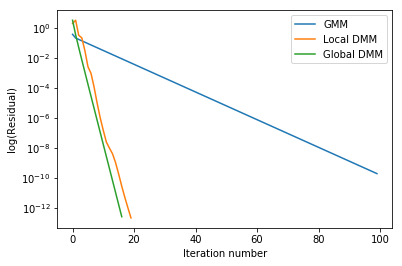

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()